In [1]:
import tifffile
import matplotlib.pyplot as plt
import trackpy as tp
import pandas as pd
import numpy as np
from skimage import io, color, filters, exposure, feature, transform
import pims

from scipy.spatial import cKDTree

/Users/virginia/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


<h1>10x 1um</h1>

<h3>Images<h3>

<h5>Run 1</h5>

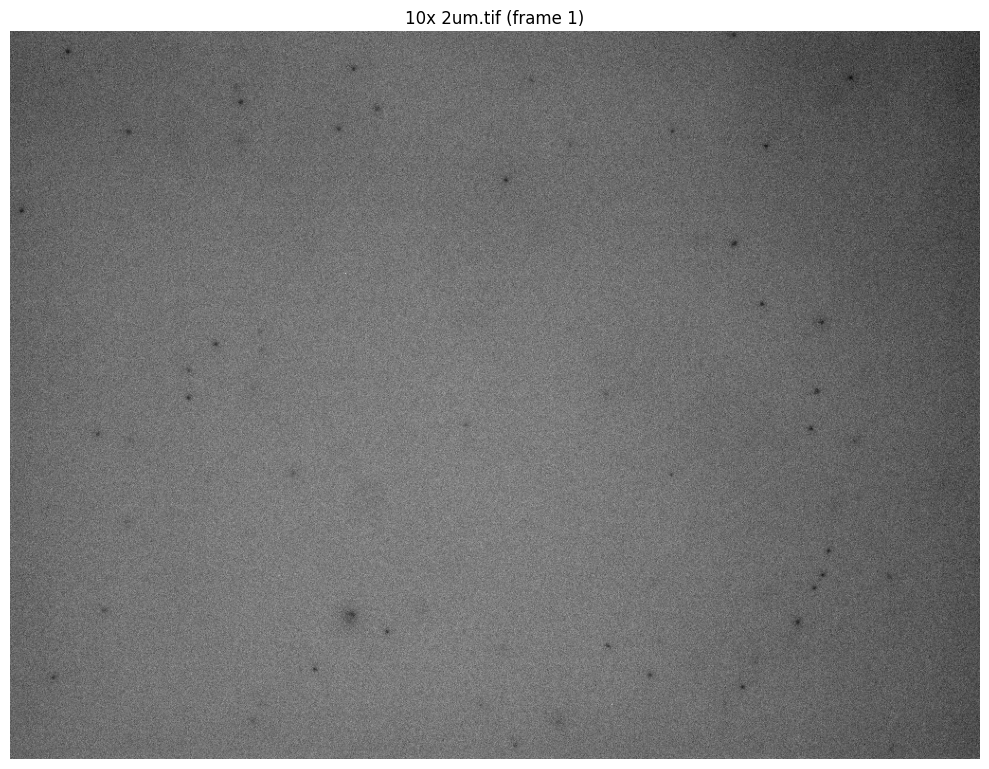

In [23]:
# === Load TIFF and select one frame ===
frames = tifffile.imread("1um/10x 1um better 1.tif")
frame = frames[0]  # adjust index if needed

# === Preprocess image ===
blurred = filters.gaussian(frame, sigma=1)
background = filters.gaussian(frame, sigma=10)
enhanced = frame - background
enhanced = exposure.rescale_intensity(enhanced)

# === Plot image with colored circles ===
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(enhanced, cmap='gray')

plt.title('10x 2um.tif (frame 1)')
plt.axis("off")
plt.tight_layout()
plt.show()


<h3>Tracking Particles</h3>

<h5>Run 1</h5>

Frame 199: 47 trajectories present.

Track durations (frames):
particle
0      200
24     200
26     200
27     200
29     200
      ... 
69       1
215      1
70       1
213      1
420      1
Length: 421, dtype: int64


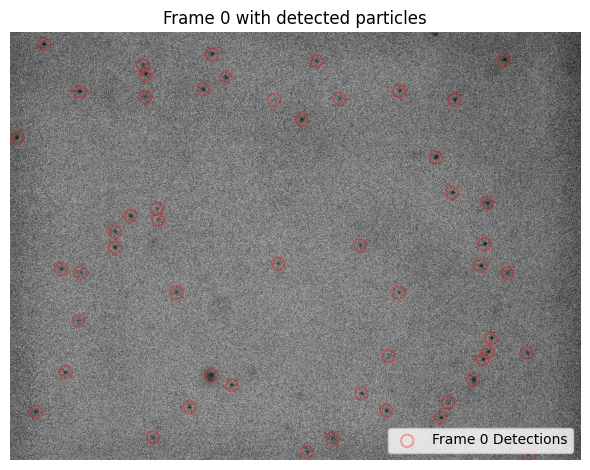

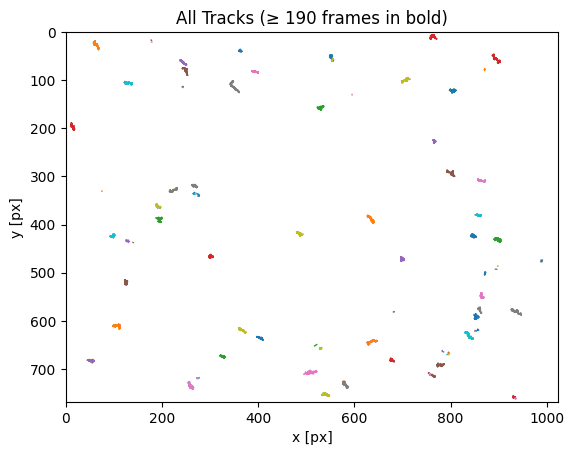

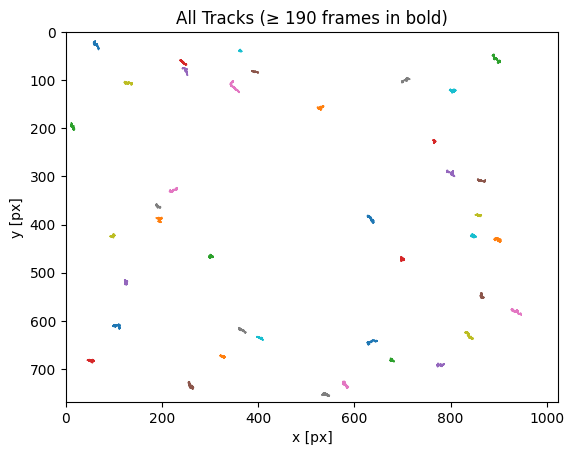

Particles tracked for exactly 200 frames: 33
Particles tracked ≥190 and <200 frames: 7
Particles tracked <190 frames (excluded from long_tracks): 381


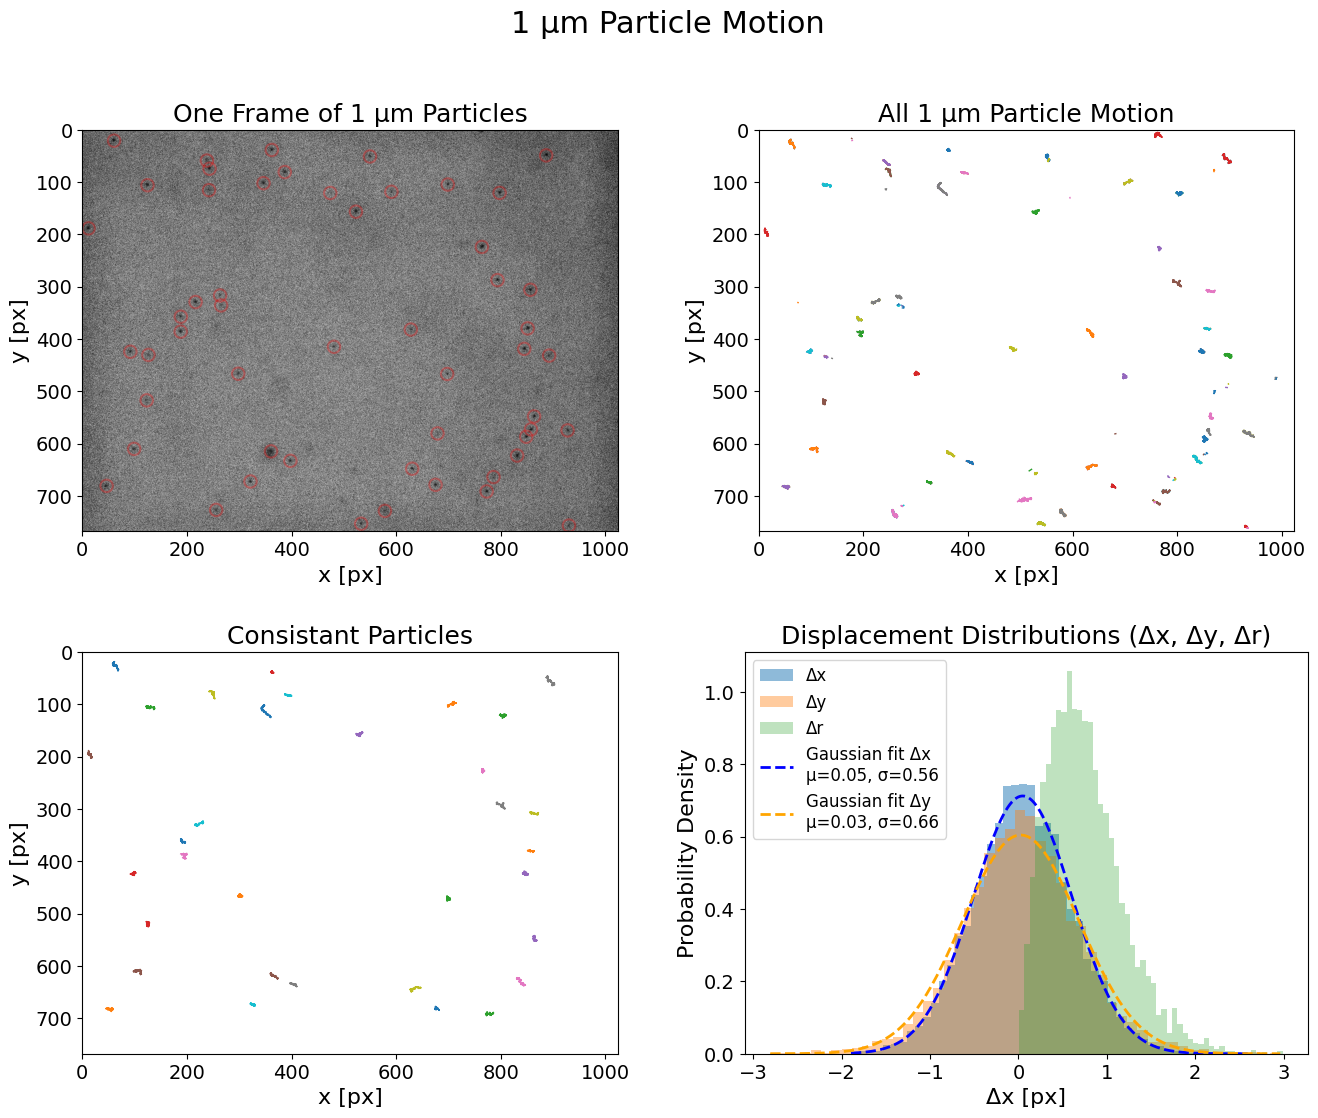

In [81]:
# === Load frames ===
frames = tifffile.imread("1um/10x 1um better 1.tif")
total_frames = len(frames)

# === Preprocess frames ===
from skimage import exposure, util

def preprocess_frame(frame):
    blurred = filters.gaussian(frame, sigma=1)
    background = filters.gaussian(frame, sigma=10)
    enhanced = frame - background
    # Convert to uint8 for CLAHE
    enhanced_uint8 = util.img_as_ubyte(exposure.rescale_intensity(enhanced))
    clahe = exposure.equalize_adapthist(enhanced_uint8, clip_limit=0.03)
    return clahe



processed_frames = [preprocess_frame(f) for f in frames]

# === Detect features ===
diameter = 13
minmass = 3
features = tp.batch(processed_frames, diameter=diameter, minmass=minmass, threshold=0.005, invert=True)

# === Link particles ===
search_range = 10
memory = 5
linked = tp.link_df(features, search_range=search_range, memory=memory)

# === Enhanced Track Merging ===
def smart_merge_tracks(df, max_dist=30, max_gap=50, min_total_frames=0.95):
    df = df.sort_values(['particle', 'frame']).copy()
    particle_groups = df.groupby('particle')
    endpoints = []

    for pid, group in particle_groups:
        frames_tracked = group['frame'].nunique()
        start_frame = group['frame'].min()
        end_frame = group['frame'].max()
        start_pos = group[group['frame'] == start_frame][['x', 'y']].values[0]
        end_pos = group[group['frame'] == end_frame][['x', 'y']].values[0]
        endpoints.append({
            'particle': pid,
            'start': start_frame,
            'end': end_frame,
            'start_pos': start_pos,
            'end_pos': end_pos,
            'length': frames_tracked
        })

    used = set()
    merged_tracks = []
    new_particle_id = 0

    for i, pi in enumerate(endpoints):
        if pi['particle'] in used:
            continue

        candidate_ids = [pi['particle']]
        total_len = pi['length']
        used.add(pi['particle'])

        for j, pj in enumerate(endpoints):
            if pj['particle'] in used or pj['particle'] == pi['particle']:
                continue

            # Case 1: pj starts shortly after pi ends
            gap_forward = pj['start'] - pi['end']
            dist_forward = np.linalg.norm(pi['end_pos'] - pj['start_pos'])

            # Case 2: pj ends shortly before pi starts
            gap_backward = pi['start'] - pj['end']
            dist_backward = np.linalg.norm(pi['start_pos'] - pj['end_pos'])

            if (0 < gap_forward <= max_gap and dist_forward <= max_dist) or \
               (0 < gap_backward <= max_gap and dist_backward <= max_dist):

                combined_len = total_len + pj['length']
                if combined_len >= min_total_frames * total_frames:
                    candidate_ids.append(pj['particle'])
                    used.add(pj['particle'])
                    total_len = combined_len

        merged_df = df[df['particle'].isin(candidate_ids)].copy()
        merged_df['particle'] = new_particle_id
        merged_tracks.append(merged_df)
        new_particle_id += 1

    merged_all = pd.concat(merged_tracks, ignore_index=True)
    merged_all = merged_all.drop_duplicates(subset=['particle', 'frame'], keep='first')
    return merged_all


# === Merge smartly ===
linked_merged = smart_merge_tracks(linked, max_dist=30, max_gap=50, min_total_frames=0.95)


# === Filter: particles tracked for at least 95% of total frames ===
min_frames = int(0.95 * total_frames)
long_tracks = tp.filter_stubs(linked_merged, threshold=min_frames)
tracks_200_1 = linked_merged.groupby('particle').filter(lambda x: len(x) == 200)


# === Show lifespans ===
print("\nTrack durations (frames):")
print(linked_merged.groupby('particle').size().sort_values(ascending=False))


#Image
frame_index = 0
frame = frames[frame_index]
processed = preprocess_frame(frame)

# Filter features for just frame 0
features_frame0 = features[features['frame'] == frame_index]

fig, ax = plt.subplots()
ax.imshow(processed, cmap='gray')

# Transparent red circles
ax.scatter(features_frame0['x'], features_frame0['y'],
           facecolors='none', edgecolors='red', s=80,
           linewidth=1.5, alpha=0.3, label='Frame 0 Detections')

ax.set_title(f"Frame {frame_index} with detected particles")
ax.axis('off')
plt.legend()
plt.tight_layout()
plt.show()



#Map of every motion detection
fig, ax = plt.subplots()
tp.plot_traj(linked_merged, ax=ax, color='gray', alpha=0.3)   # all tracks
tp.plot_traj(long_tracks, ax=ax, lw=2)                        # long-lived bold

plt.xlim(0, frames[0].shape[1])     # width
plt.ylim(frames[0].shape[0], 0)     # full height
plt.gca().set_aspect('equal')
plt.title(f"All Tracks (≥ {min_frames} frames in bold)")
plt.show()

#Map of only particle motion detection
fig, ax = plt.subplots()
tp.plot_traj(long_tracks, ax=ax, lw=2)                        # long-lived bold

# === Fix y-axis and aspect ===
plt.xlim(0, frames[0].shape[1])     # width
plt.ylim(frames[0].shape[0], 0)     # full height
plt.gca().set_aspect('equal')
plt.title(f"All Tracks (≥ {min_frames} frames in bold)")
plt.show()

# Get total number of frames (should be 200 in your case)
total_frames = 200
long_threshold = int(0.95 * total_frames)  # e.g., 190

# Step 1: Compute track lengths from linked_merged
track_lengths = linked_merged.groupby('particle')['frame'].nunique()

# Step 2: Full 200-frame particles
full_200 = track_lengths[track_lengths == total_frames]

# Step 3: Long-lived particles that passed threshold but not 200
long_but_not_200 = track_lengths[(track_lengths >= long_threshold) & (track_lengths < total_frames)]

# Step 4: Particles that did not pass the 95% threshold (i.e., not in long_tracks)
all_particles = set(linked_merged['particle'].unique())
long_tracked_particles = set(long_tracks['particle'].unique())
short_lived_particles = all_particles - long_tracked_particles

# Print results
print(f"Particles tracked for exactly 200 frames: {len(full_200)}")
print(f"Particles tracked ≥{long_threshold} and <200 frames: {len(long_but_not_200)}")
print(f"Particles tracked <{long_threshold} frames (excluded from long_tracks): {len(short_lived_particles)}")



# === Compute full_200 only once ===
track_lengths = linked_merged.groupby('particle')['frame'].nunique()
full_200_ids = track_lengths[track_lengths == 200].index
full_200 = linked_merged[linked_merged['particle'].isin(full_200_ids)]


import matplotlib.gridspec as gridspec

# === Counts for text panel ===
n_full = 33         # exactly 200-frame tracks
n_long = 7          # 190–199 frames
n_short = 381       # everything else

# === Set up figure with GridSpec layout ===
fig = plt.figure(figsize=(16, 12))
fig.suptitle("1 μm Particle Motion", fontsize=22)
gs = gridspec.GridSpec(2, 2, figure=fig, height_ratios=[1, 1], width_ratios=[1, 1])
gs.update(hspace=0.3, wspace=0.2)

# === ax1: Frame 0 detections ===
ax1 = fig.add_subplot(gs[0, 0])
ax1.imshow(processed, cmap='gray')
ax1.scatter(features_frame0['x'], features_frame0['y'],
            facecolors='none', edgecolors='red', s=80,
            linewidth=1.5, alpha=0.3)
ax1.set_title("One Frame of 1 μm Particles", fontsize=18)
ax1.set_xlabel("x [px]", fontsize=16)
ax1.set_ylabel("y [px]", fontsize=16)
ax1.set_xlim(0, frames[0].shape[1])
ax1.set_ylim(frames[0].shape[0], 0)
ax1.set_aspect('equal')
ax1.tick_params(axis='both', labelsize=14)

# === ax2: All particle motion ===
ax2 = fig.add_subplot(gs[0, 1])
tp.plot_traj(linked_merged, ax=ax2, color='gray', alpha=0.3)
tp.plot_traj(long_tracks, ax=ax2, lw=2)
ax2.set_title("All 1 μm Particle Motion", fontsize=18)
ax2.set_xlabel("x [px]", fontsize=16)
ax2.set_ylabel("y [px]", fontsize=16)
ax2.set_xlim(0, frames[0].shape[1])
ax2.set_ylim(frames[0].shape[0], 0)
ax2.set_aspect('equal')
ax2.tick_params(axis='both', labelsize=14)

# === ax3: Full-length tracks ===
ax3 = fig.add_subplot(gs[1, 0])
tp.plot_traj(full_200, ax=ax3, lw=2)
ax3.set_title("Consistant Particles", fontsize=18)
ax3.set_xlabel("x [px]", fontsize=16)
ax3.set_ylabel("y [px]", fontsize=16)
ax3.set_xlim(0, frames[0].shape[1])
ax3.set_ylim(frames[0].shape[0], 0)
ax3.set_aspect('equal')
ax3.tick_params(axis='both', labelsize=14)

from scipy.stats import norm

# === Compute displacements over 1-frame lag ===
lag = 1
disp_df = tp.compute_drift(linked_merged, smoothing=0)  # subtract global drift if any
deltas = []

for pid, group in linked_merged.groupby('particle'):
    group = group.sort_values('frame')
    group = group.reset_index(drop=True)
    dx = group['x'].diff(lag)
    dy = group['y'].diff(lag)
    dr = np.sqrt(dx**2 + dy**2)
    deltas.extend(dx[lag:].dropna())  # use dx OR dr if you want magnitude

deltas = np.array(deltas)

from scipy.stats import norm

# === ax4: Histogram of Δx for full_200 tracks only ===
ax4 = fig.add_subplot(gs[1, 1])
ax4.set_title("Displacement Distribution (Δx)", fontsize=18)

# === Compute Δx displacements from full_200 (1-frame lag) ===
from scipy.stats import norm

# === Compute displacements from full_200 for Δx, Δy, and Δr (1-frame lag) ===
dx_all = []
dy_all = []
dr_all = []

for pid, group in full_200.groupby('particle'):
    group = group.sort_values('frame').reset_index(drop=True)
    dx = group['x'].diff().dropna()
    dy = group['y'].diff().dropna()
    dr = np.sqrt(dx**2 + dy**2)
    dx_all.extend(dx)
    dy_all.extend(dy)
    dr_all.extend(dr)

dx_all = np.array(dx_all)
dy_all = np.array(dy_all)
dr_all = np.array(dr_all)

# === Clear ax4 and plot combined histograms ===
ax4.clear()
ax4.set_title("Displacement Distributions (Δx, Δy, Δr)", fontsize=18)

bins = 50

# Plot histograms with different colors and alphas
ax4.hist(dx_all, bins=bins, density=True, alpha=0.5, color='tab:blue', label='Δx')
ax4.hist(dy_all, bins=bins, density=True, alpha=0.4, color='tab:orange', label='Δy')
ax4.hist(dr_all, bins=bins, density=True, alpha=0.3, color='tab:green', label='Δr')

# Fit and plot Gaussian PDFs for Δx and Δy only
mu_x, std_x = norm.fit(dx_all)
mu_y, std_y = norm.fit(dy_all)

x_vals_x = np.linspace(min(dx_all), max(dx_all), 200)
pdf_x = norm.pdf(x_vals_x, mu_x, std_x)
ax4.plot(x_vals_x, pdf_x, 'b--', lw=2, label=f'Gaussian fit Δx\nμ={mu_x:.2f}, σ={std_x:.2f}')

x_vals_y = np.linspace(min(dy_all), max(dy_all), 200)
pdf_y = norm.pdf(x_vals_y, mu_y, std_y)
ax4.plot(x_vals_y, pdf_y, color='orange', linestyle='--', lw=2, label=f'Gaussian fit Δy\nμ={mu_y:.2f}, σ={std_y:.2f}')

# === Labels and ticks ===
ax4.set_xlabel("Δx [px]", fontsize=16)
ax4.set_ylabel("Probability Density", fontsize=16)
ax4.tick_params(axis='both', labelsize=14)
ax4.legend(fontsize=12)

plt.savefig('1mumfullplot')

plt.show()



<h5>Run 2<h5>

Frame 199: 35 trajectories present.

Track durations (frames):
particle
0      200
14     200
35     200
34     200
38     200
      ... 
217      1
216      1
214      1
213      1
555      1
Length: 556, dtype: int64


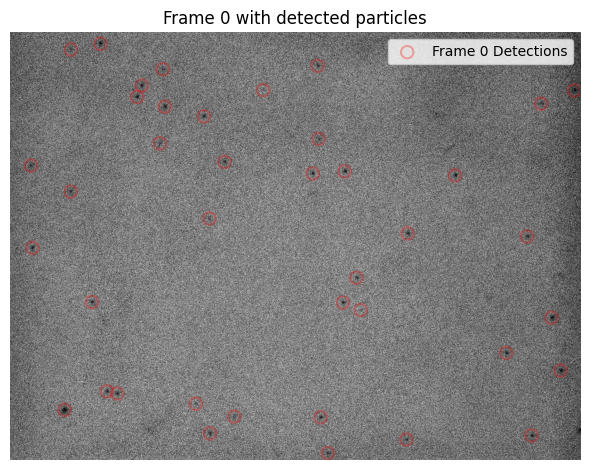

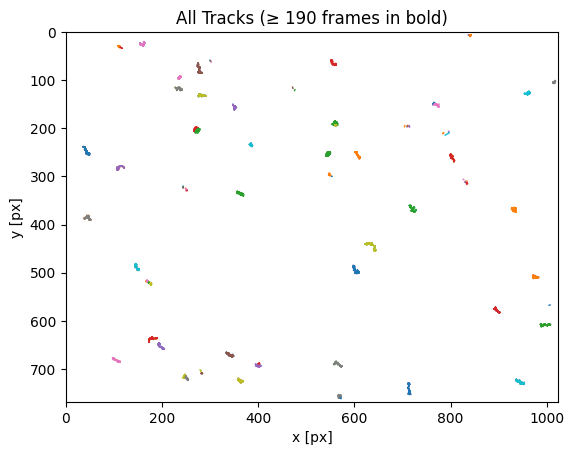

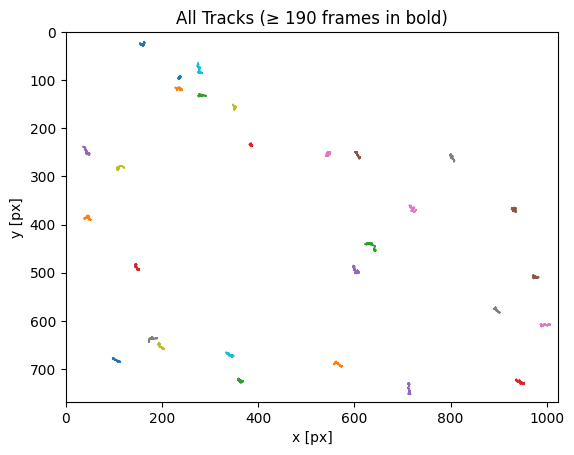

Particles tracked for exactly 200 frames: 24
Particles tracked ≥190 and <200 frames: 5
Particles tracked <190 frames (excluded from long_tracks): 527


In [40]:
# === Load frames ===
frames = tifffile.imread("1um/10x 1um better 2.tif")
total_frames = len(frames)

# === Preprocess frames ===
from skimage import exposure, util

def preprocess_frame(frame):
    blurred = filters.gaussian(frame, sigma=1)
    background = filters.gaussian(frame, sigma=10)
    enhanced = frame - background
    # Convert to uint8 for CLAHE
    enhanced_uint8 = util.img_as_ubyte(exposure.rescale_intensity(enhanced))
    clahe = exposure.equalize_adapthist(enhanced_uint8, clip_limit=0.03)
    return clahe



processed_frames = [preprocess_frame(f) for f in frames]

# === Detect features ===
diameter = 13
minmass = 3
features = tp.batch(processed_frames, diameter=diameter, minmass=minmass, threshold=0.005, invert=True)

# === Link particles ===
search_range = 10
memory = 5
linked = tp.link_df(features, search_range=search_range, memory=memory)

# === Enhanced Track Merging ===
def smart_merge_tracks(df, max_dist=30, max_gap=50, min_total_frames=0.95):
    df = df.sort_values(['particle', 'frame']).copy()
    particle_groups = df.groupby('particle')
    endpoints = []

    for pid, group in particle_groups:
        frames_tracked = group['frame'].nunique()
        start_frame = group['frame'].min()
        end_frame = group['frame'].max()
        start_pos = group[group['frame'] == start_frame][['x', 'y']].values[0]
        end_pos = group[group['frame'] == end_frame][['x', 'y']].values[0]
        endpoints.append({
            'particle': pid,
            'start': start_frame,
            'end': end_frame,
            'start_pos': start_pos,
            'end_pos': end_pos,
            'length': frames_tracked
        })

    used = set()
    merged_tracks = []
    new_particle_id = 0

    for i, pi in enumerate(endpoints):
        if pi['particle'] in used:
            continue

        candidate_ids = [pi['particle']]
        total_len = pi['length']
        used.add(pi['particle'])

        for j, pj in enumerate(endpoints):
            if pj['particle'] in used or pj['particle'] == pi['particle']:
                continue

            # Case 1: pj starts shortly after pi ends
            gap_forward = pj['start'] - pi['end']
            dist_forward = np.linalg.norm(pi['end_pos'] - pj['start_pos'])

            # Case 2: pj ends shortly before pi starts
            gap_backward = pi['start'] - pj['end']
            dist_backward = np.linalg.norm(pi['start_pos'] - pj['end_pos'])

            if (0 < gap_forward <= max_gap and dist_forward <= max_dist) or \
               (0 < gap_backward <= max_gap and dist_backward <= max_dist):

                combined_len = total_len + pj['length']
                if combined_len >= min_total_frames * total_frames:
                    candidate_ids.append(pj['particle'])
                    used.add(pj['particle'])
                    total_len = combined_len

        merged_df = df[df['particle'].isin(candidate_ids)].copy()
        merged_df['particle'] = new_particle_id
        merged_tracks.append(merged_df)
        new_particle_id += 1

    merged_all = pd.concat(merged_tracks, ignore_index=True)
    merged_all = merged_all.drop_duplicates(subset=['particle', 'frame'], keep='first')
    return merged_all


# === Merge smartly ===
linked_merged = smart_merge_tracks(linked, max_dist=30, max_gap=50, min_total_frames=0.95)


# === Filter: particles tracked for at least 95% of total frames ===
min_frames = int(0.95 * total_frames)
long_tracks = tp.filter_stubs(linked_merged, threshold=min_frames)
tracks_200_2 = linked_merged.groupby('particle').filter(lambda x: len(x) == 200)

# === Show lifespans ===
print("\nTrack durations (frames):")
print(linked_merged.groupby('particle').size().sort_values(ascending=False))


#Image
frame_index = 0
frame = frames[frame_index]
processed = preprocess_frame(frame)

# Filter features for just frame 0
features_frame0 = features[features['frame'] == frame_index]

fig, ax = plt.subplots()
ax.imshow(processed, cmap='gray')

# Transparent red circles
ax.scatter(features_frame0['x'], features_frame0['y'],
           facecolors='none', edgecolors='red', s=80,
           linewidth=1.5, alpha=0.3, label='Frame 0 Detections')

ax.set_title(f"Frame {frame_index} with detected particles")
ax.axis('off')
plt.legend()
plt.tight_layout()
plt.show()



#Map of every motion detection
fig, ax = plt.subplots()
tp.plot_traj(linked_merged, ax=ax, color='gray', alpha=0.3)   # all tracks
tp.plot_traj(long_tracks, ax=ax, lw=2)                        # long-lived bold

plt.xlim(0, frames[0].shape[1])     # width
plt.ylim(frames[0].shape[0], 0)     # full height
plt.gca().set_aspect('equal')
plt.title(f"All Tracks (≥ {min_frames} frames in bold)")
plt.show()

#Map of only particle motion detection
fig, ax = plt.subplots()
tp.plot_traj(long_tracks, ax=ax, lw=2)                        # long-lived bold

# === Fix y-axis and aspect ===
plt.xlim(0, frames[0].shape[1])     # width
plt.ylim(frames[0].shape[0], 0)     # full height
plt.gca().set_aspect('equal')
plt.title(f"All Tracks (≥ {min_frames} frames in bold)")
plt.show()

# Get total number of frames (should be 200 in your case)
total_frames = 200
long_threshold = int(0.95 * total_frames)  # e.g., 190

# Step 1: Compute track lengths from linked_merged
track_lengths = linked_merged.groupby('particle')['frame'].nunique()

# Step 2: Full 200-frame particles
full_200 = track_lengths[track_lengths == total_frames]

# Step 3: Long-lived particles that passed threshold but not 200
long_but_not_200 = track_lengths[(track_lengths >= long_threshold) & (track_lengths < total_frames)]

# Step 4: Particles that did not pass the 95% threshold (i.e., not in long_tracks)
all_particles = set(linked_merged['particle'].unique())
long_tracked_particles = set(long_tracks['particle'].unique())
short_lived_particles = all_particles - long_tracked_particles

# Print results
print(f"Particles tracked for exactly 200 frames: {len(full_200)}")
print(f"Particles tracked ≥{long_threshold} and <200 frames: {len(long_but_not_200)}")
print(f"Particles tracked <{long_threshold} frames (excluded from long_tracks): {len(short_lived_particles)}")


<h5>Run 3<h5>

Frame 199: 40 trajectories present.

Track durations (frames):
particle
29     200
17     200
30     200
33     200
28     200
      ... 
269      1
271      1
272      1
273      1
695      1
Length: 696, dtype: int64


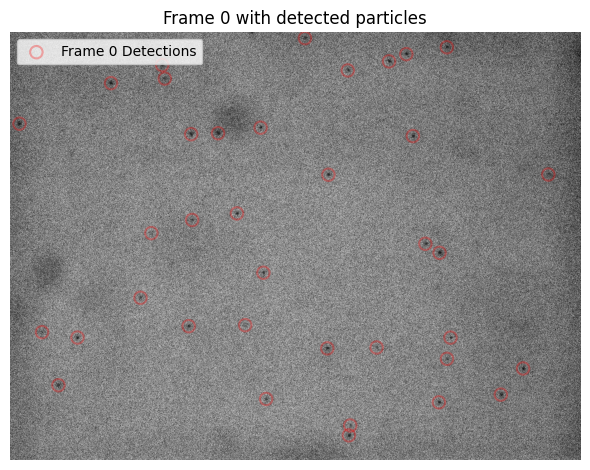

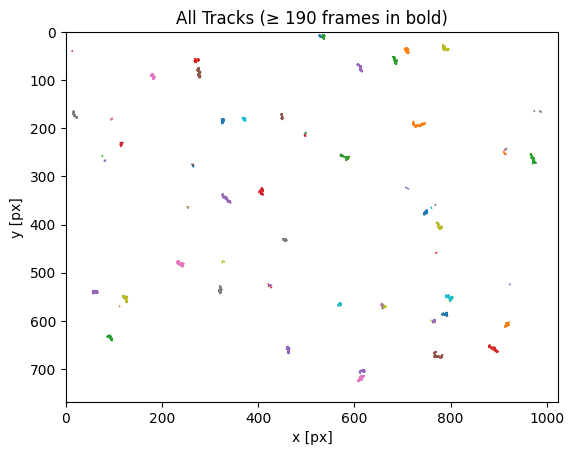

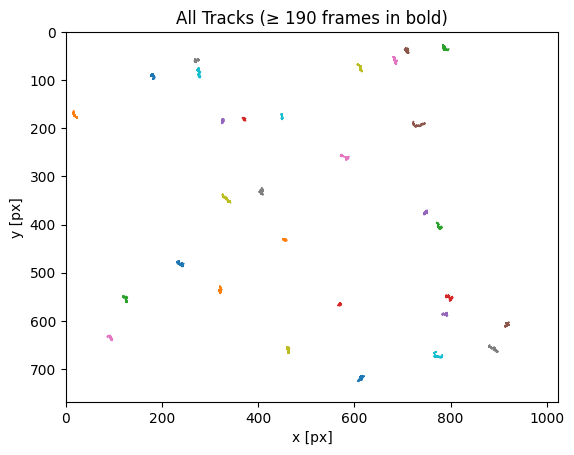

Particles tracked for exactly 200 frames: 26
Particles tracked ≥190 and <200 frames: 4
Particles tracked <190 frames (excluded from long_tracks): 666


In [41]:
# === Load frames ===
frames = tifffile.imread("1um/10x 1um better 3.tif")
total_frames = len(frames)

# === Preprocess frames ===
from skimage import exposure, util

def preprocess_frame(frame):
    blurred = filters.gaussian(frame, sigma=1)
    background = filters.gaussian(frame, sigma=10)
    enhanced = frame - background
    # Convert to uint8 for CLAHE
    enhanced_uint8 = util.img_as_ubyte(exposure.rescale_intensity(enhanced))
    clahe = exposure.equalize_adapthist(enhanced_uint8, clip_limit=0.03)
    return clahe



processed_frames = [preprocess_frame(f) for f in frames]

# === Detect features ===
diameter = 13
minmass = 3
features = tp.batch(processed_frames, diameter=diameter, minmass=minmass, threshold=0.005, invert=True)

# === Link particles ===
search_range = 10
memory = 5
linked = tp.link_df(features, search_range=search_range, memory=memory)

# === Enhanced Track Merging ===
def smart_merge_tracks(df, max_dist=30, max_gap=50, min_total_frames=0.95):
    df = df.sort_values(['particle', 'frame']).copy()
    particle_groups = df.groupby('particle')
    endpoints = []

    for pid, group in particle_groups:
        frames_tracked = group['frame'].nunique()
        start_frame = group['frame'].min()
        end_frame = group['frame'].max()
        start_pos = group[group['frame'] == start_frame][['x', 'y']].values[0]
        end_pos = group[group['frame'] == end_frame][['x', 'y']].values[0]
        endpoints.append({
            'particle': pid,
            'start': start_frame,
            'end': end_frame,
            'start_pos': start_pos,
            'end_pos': end_pos,
            'length': frames_tracked
        })

    used = set()
    merged_tracks = []
    new_particle_id = 0

    for i, pi in enumerate(endpoints):
        if pi['particle'] in used:
            continue

        candidate_ids = [pi['particle']]
        total_len = pi['length']
        used.add(pi['particle'])

        for j, pj in enumerate(endpoints):
            if pj['particle'] in used or pj['particle'] == pi['particle']:
                continue

            # Case 1: pj starts shortly after pi ends
            gap_forward = pj['start'] - pi['end']
            dist_forward = np.linalg.norm(pi['end_pos'] - pj['start_pos'])

            # Case 2: pj ends shortly before pi starts
            gap_backward = pi['start'] - pj['end']
            dist_backward = np.linalg.norm(pi['start_pos'] - pj['end_pos'])

            if (0 < gap_forward <= max_gap and dist_forward <= max_dist) or \
               (0 < gap_backward <= max_gap and dist_backward <= max_dist):

                combined_len = total_len + pj['length']
                if combined_len >= min_total_frames * total_frames:
                    candidate_ids.append(pj['particle'])
                    used.add(pj['particle'])
                    total_len = combined_len

        merged_df = df[df['particle'].isin(candidate_ids)].copy()
        merged_df['particle'] = new_particle_id
        merged_tracks.append(merged_df)
        new_particle_id += 1

    merged_all = pd.concat(merged_tracks, ignore_index=True)
    merged_all = merged_all.drop_duplicates(subset=['particle', 'frame'], keep='first')
    return merged_all


# === Merge smartly ===
linked_merged = smart_merge_tracks(linked, max_dist=30, max_gap=50, min_total_frames=0.95)


# === Filter: particles tracked for at least 95% of total frames ===
min_frames = int(0.95 * total_frames)
long_tracks = tp.filter_stubs(linked_merged, threshold=min_frames)
tracks_200_3 = linked_merged.groupby('particle').filter(lambda x: len(x) == 200)

# === Show lifespans ===
print("\nTrack durations (frames):")
print(linked_merged.groupby('particle').size().sort_values(ascending=False))


#Image
frame_index = 0
frame = frames[frame_index]
processed = preprocess_frame(frame)

# Filter features for just frame 0
features_frame0 = features[features['frame'] == frame_index]

fig, ax = plt.subplots()
ax.imshow(processed, cmap='gray')

# Transparent red circles
ax.scatter(features_frame0['x'], features_frame0['y'],
           facecolors='none', edgecolors='red', s=80,
           linewidth=1.5, alpha=0.3, label='Frame 0 Detections')

ax.set_title(f"Frame {frame_index} with detected particles")
ax.axis('off')
plt.legend()
plt.tight_layout()
plt.show()



#Map of every motion detection
fig, ax = plt.subplots()
tp.plot_traj(linked_merged, ax=ax, color='gray', alpha=0.3)   # all tracks
tp.plot_traj(long_tracks, ax=ax, lw=2)                        # long-lived bold

plt.xlim(0, frames[0].shape[1])     # width
plt.ylim(frames[0].shape[0], 0)     # full height
plt.gca().set_aspect('equal')
plt.title(f"All Tracks (≥ {min_frames} frames in bold)")
plt.show()

#Map of only particle motion detection
fig, ax = plt.subplots()
tp.plot_traj(long_tracks, ax=ax, lw=2)                        # long-lived bold

# === Fix y-axis and aspect ===
plt.xlim(0, frames[0].shape[1])     # width
plt.ylim(frames[0].shape[0], 0)     # full height
plt.gca().set_aspect('equal')
plt.title(f"All Tracks (≥ {min_frames} frames in bold)")
plt.show()

# Get total number of frames (should be 200 in your case)
total_frames = 200
long_threshold = int(0.95 * total_frames)  # e.g., 190

# Step 1: Compute track lengths from linked_merged
track_lengths = linked_merged.groupby('particle')['frame'].nunique()

# Step 2: Full 200-frame particles
full_200 = track_lengths[track_lengths == total_frames]

# Step 3: Long-lived particles that passed threshold but not 200
long_but_not_200 = track_lengths[(track_lengths >= long_threshold) & (track_lengths < total_frames)]

# Step 4: Particles that did not pass the 95% threshold (i.e., not in long_tracks)
all_particles = set(linked_merged['particle'].unique())
long_tracked_particles = set(long_tracks['particle'].unique())
short_lived_particles = all_particles - long_tracked_particles

# Print results
print(f"Particles tracked for exactly 200 frames: {len(full_200)}")
print(f"Particles tracked ≥{long_threshold} and <200 frames: {len(long_but_not_200)}")
print(f"Particles tracked <{long_threshold} frames (excluded from long_tracks): {len(short_lived_particles)}")


<h5>Run 4<h5>

Frame 199: 39 trajectories present.

Track durations (frames):
particle
32     200
14     200
35     200
31     200
30     200
      ... 
239      1
238      1
237      1
236      1
614      1
Length: 615, dtype: int64


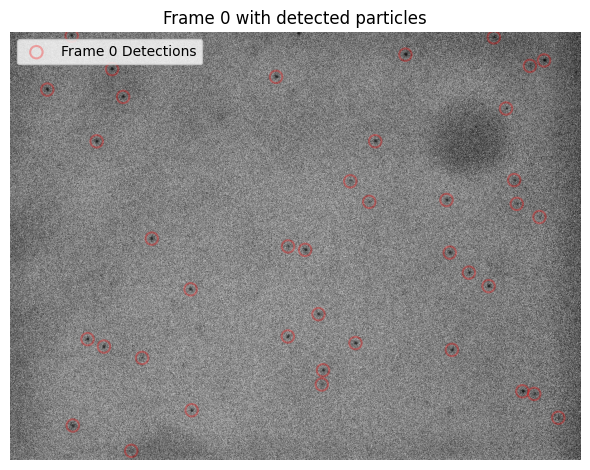

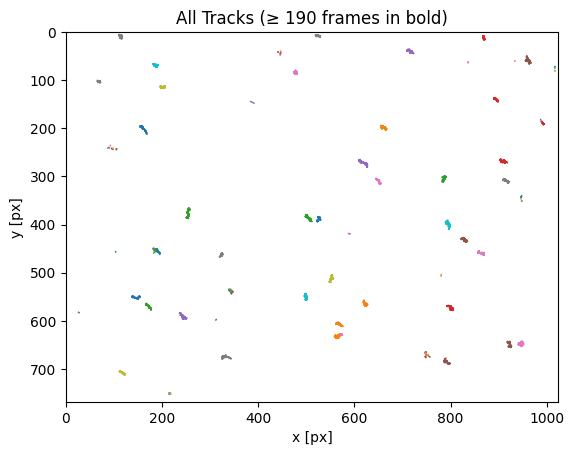

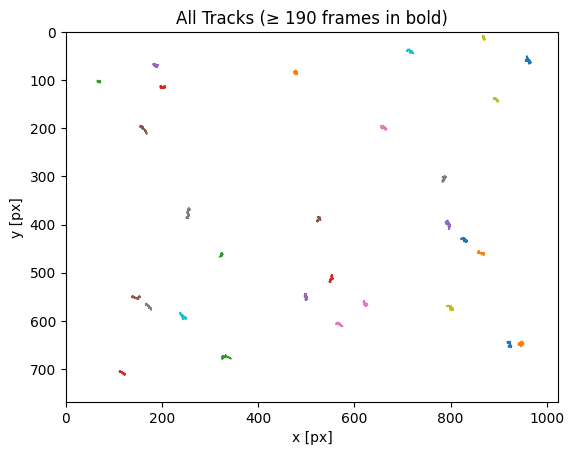

Particles tracked for exactly 200 frames: 25
Particles tracked ≥190 and <200 frames: 4
Particles tracked <190 frames (excluded from long_tracks): 586


In [42]:
# === Load frames ===
frames = tifffile.imread("1um/10x 1um better 4.tif")
total_frames = len(frames)

# === Preprocess frames ===
from skimage import exposure, util

def preprocess_frame(frame):
    blurred = filters.gaussian(frame, sigma=1)
    background = filters.gaussian(frame, sigma=10)
    enhanced = frame - background
    # Convert to uint8 for CLAHE
    enhanced_uint8 = util.img_as_ubyte(exposure.rescale_intensity(enhanced))
    clahe = exposure.equalize_adapthist(enhanced_uint8, clip_limit=0.03)
    return clahe



processed_frames = [preprocess_frame(f) for f in frames]

# === Detect features ===
diameter = 13
minmass = 3
features = tp.batch(processed_frames, diameter=diameter, minmass=minmass, threshold=0.005, invert=True)

# === Link particles ===
search_range = 10
memory = 5
linked = tp.link_df(features, search_range=search_range, memory=memory)

# === Enhanced Track Merging ===
def smart_merge_tracks(df, max_dist=30, max_gap=50, min_total_frames=0.95):
    df = df.sort_values(['particle', 'frame']).copy()
    particle_groups = df.groupby('particle')
    endpoints = []

    for pid, group in particle_groups:
        frames_tracked = group['frame'].nunique()
        start_frame = group['frame'].min()
        end_frame = group['frame'].max()
        start_pos = group[group['frame'] == start_frame][['x', 'y']].values[0]
        end_pos = group[group['frame'] == end_frame][['x', 'y']].values[0]
        endpoints.append({
            'particle': pid,
            'start': start_frame,
            'end': end_frame,
            'start_pos': start_pos,
            'end_pos': end_pos,
            'length': frames_tracked
        })

    used = set()
    merged_tracks = []
    new_particle_id = 0

    for i, pi in enumerate(endpoints):
        if pi['particle'] in used:
            continue

        candidate_ids = [pi['particle']]
        total_len = pi['length']
        used.add(pi['particle'])

        for j, pj in enumerate(endpoints):
            if pj['particle'] in used or pj['particle'] == pi['particle']:
                continue

            # Case 1: pj starts shortly after pi ends
            gap_forward = pj['start'] - pi['end']
            dist_forward = np.linalg.norm(pi['end_pos'] - pj['start_pos'])

            # Case 2: pj ends shortly before pi starts
            gap_backward = pi['start'] - pj['end']
            dist_backward = np.linalg.norm(pi['start_pos'] - pj['end_pos'])

            if (0 < gap_forward <= max_gap and dist_forward <= max_dist) or \
               (0 < gap_backward <= max_gap and dist_backward <= max_dist):

                combined_len = total_len + pj['length']
                if combined_len >= min_total_frames * total_frames:
                    candidate_ids.append(pj['particle'])
                    used.add(pj['particle'])
                    total_len = combined_len

        merged_df = df[df['particle'].isin(candidate_ids)].copy()
        merged_df['particle'] = new_particle_id
        merged_tracks.append(merged_df)
        new_particle_id += 1

    merged_all = pd.concat(merged_tracks, ignore_index=True)
    merged_all = merged_all.drop_duplicates(subset=['particle', 'frame'], keep='first')
    return merged_all


# === Merge smartly ===
linked_merged = smart_merge_tracks(linked, max_dist=30, max_gap=50, min_total_frames=0.95)


# === Filter: particles tracked for at least 95% of total frames ===
min_frames = int(0.95 * total_frames)
long_tracks = tp.filter_stubs(linked_merged, threshold=min_frames)
tracks_200_4 = linked_merged.groupby('particle').filter(lambda x: len(x) == 200)

# === Show lifespans ===
print("\nTrack durations (frames):")
print(linked_merged.groupby('particle').size().sort_values(ascending=False))


#Image
frame_index = 0
frame = frames[frame_index]
processed = preprocess_frame(frame)

# Filter features for just frame 0
features_frame0 = features[features['frame'] == frame_index]

fig, ax = plt.subplots()
ax.imshow(processed, cmap='gray')

# Transparent red circles
ax.scatter(features_frame0['x'], features_frame0['y'],
           facecolors='none', edgecolors='red', s=80,
           linewidth=1.5, alpha=0.3, label='Frame 0 Detections')

ax.set_title(f"Frame {frame_index} with detected particles")
ax.axis('off')
plt.legend()
plt.tight_layout()
plt.show()



#Map of every motion detection
fig, ax = plt.subplots()
tp.plot_traj(linked_merged, ax=ax, color='gray', alpha=0.3)   # all tracks
tp.plot_traj(long_tracks, ax=ax, lw=2)                        # long-lived bold

plt.xlim(0, frames[0].shape[1])     # width
plt.ylim(frames[0].shape[0], 0)     # full height
plt.gca().set_aspect('equal')
plt.title(f"All Tracks (≥ {min_frames} frames in bold)")
plt.show()

#Map of only particle motion detection
fig, ax = plt.subplots()
tp.plot_traj(long_tracks, ax=ax, lw=2)                        # long-lived bold

# === Fix y-axis and aspect ===
plt.xlim(0, frames[0].shape[1])     # width
plt.ylim(frames[0].shape[0], 0)     # full height
plt.gca().set_aspect('equal')
plt.title(f"All Tracks (≥ {min_frames} frames in bold)")
plt.show()

# Get total number of frames (should be 200 in your case)
total_frames = 200
long_threshold = int(0.95 * total_frames)  # e.g., 190

# Step 1: Compute track lengths from linked_merged
track_lengths = linked_merged.groupby('particle')['frame'].nunique()

# Step 2: Full 200-frame particles
full_200 = track_lengths[track_lengths == total_frames]

# Step 3: Long-lived particles that passed threshold but not 200
long_but_not_200 = track_lengths[(track_lengths >= long_threshold) & (track_lengths < total_frames)]

# Step 4: Particles that did not pass the 95% threshold (i.e., not in long_tracks)
all_particles = set(linked_merged['particle'].unique())
long_tracked_particles = set(long_tracks['particle'].unique())
short_lived_particles = all_particles - long_tracked_particles

# Print results
print(f"Particles tracked for exactly 200 frames: {len(full_200)}")
print(f"Particles tracked ≥{long_threshold} and <200 frames: {len(long_but_not_200)}")
print(f"Particles tracked <{long_threshold} frames (excluded from long_tracks): {len(short_lived_particles)}")


<h5>Run 5<h5>

Frame 199: 43 trajectories present.

Track durations (frames):
particle
28     200
24     200
26     200
29     200
20     200
      ... 
147      1
148      1
149      1
150      1
316      1
Length: 317, dtype: int64


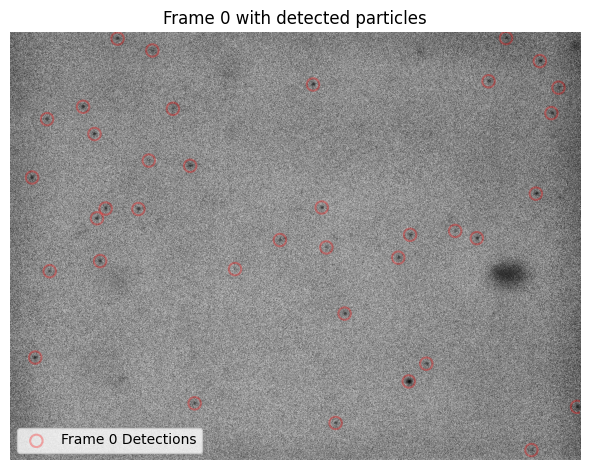

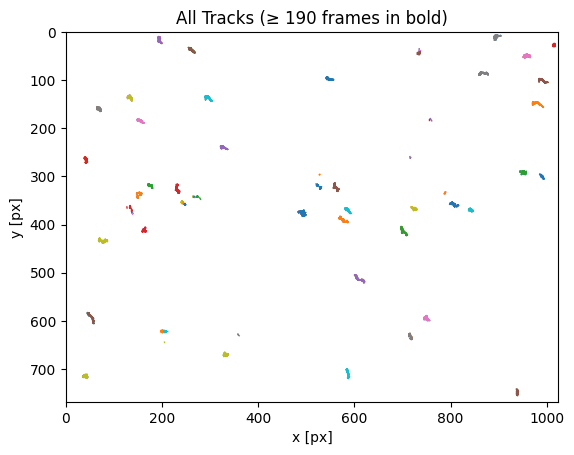

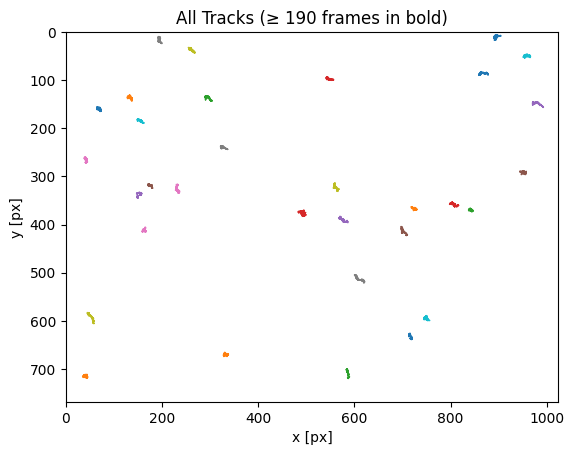

Particles tracked for exactly 200 frames: 24
Particles tracked ≥190 and <200 frames: 8
Particles tracked <190 frames (excluded from long_tracks): 285


In [43]:
# === Load frames ===
frames = tifffile.imread("1um/10x 1um better 5.tif")
total_frames = len(frames)

# === Preprocess frames ===
from skimage import exposure, util

def preprocess_frame(frame):
    blurred = filters.gaussian(frame, sigma=1)
    background = filters.gaussian(frame, sigma=10)
    enhanced = frame - background
    # Convert to uint8 for CLAHE
    enhanced_uint8 = util.img_as_ubyte(exposure.rescale_intensity(enhanced))
    clahe = exposure.equalize_adapthist(enhanced_uint8, clip_limit=0.03)
    return clahe



processed_frames = [preprocess_frame(f) for f in frames]

# === Detect features ===
diameter = 13
minmass = 3
features = tp.batch(processed_frames, diameter=diameter, minmass=minmass, threshold=0.005, invert=True)

# === Link particles ===
search_range = 10
memory = 5
linked = tp.link_df(features, search_range=search_range, memory=memory)

# === Enhanced Track Merging ===
def smart_merge_tracks(df, max_dist=30, max_gap=50, min_total_frames=0.95):
    df = df.sort_values(['particle', 'frame']).copy()
    particle_groups = df.groupby('particle')
    endpoints = []

    for pid, group in particle_groups:
        frames_tracked = group['frame'].nunique()
        start_frame = group['frame'].min()
        end_frame = group['frame'].max()
        start_pos = group[group['frame'] == start_frame][['x', 'y']].values[0]
        end_pos = group[group['frame'] == end_frame][['x', 'y']].values[0]
        endpoints.append({
            'particle': pid,
            'start': start_frame,
            'end': end_frame,
            'start_pos': start_pos,
            'end_pos': end_pos,
            'length': frames_tracked
        })

    used = set()
    merged_tracks = []
    new_particle_id = 0

    for i, pi in enumerate(endpoints):
        if pi['particle'] in used:
            continue

        candidate_ids = [pi['particle']]
        total_len = pi['length']
        used.add(pi['particle'])

        for j, pj in enumerate(endpoints):
            if pj['particle'] in used or pj['particle'] == pi['particle']:
                continue

            # Case 1: pj starts shortly after pi ends
            gap_forward = pj['start'] - pi['end']
            dist_forward = np.linalg.norm(pi['end_pos'] - pj['start_pos'])

            # Case 2: pj ends shortly before pi starts
            gap_backward = pi['start'] - pj['end']
            dist_backward = np.linalg.norm(pi['start_pos'] - pj['end_pos'])

            if (0 < gap_forward <= max_gap and dist_forward <= max_dist) or \
               (0 < gap_backward <= max_gap and dist_backward <= max_dist):

                combined_len = total_len + pj['length']
                if combined_len >= min_total_frames * total_frames:
                    candidate_ids.append(pj['particle'])
                    used.add(pj['particle'])
                    total_len = combined_len

        merged_df = df[df['particle'].isin(candidate_ids)].copy()
        merged_df['particle'] = new_particle_id
        merged_tracks.append(merged_df)
        new_particle_id += 1

    merged_all = pd.concat(merged_tracks, ignore_index=True)
    merged_all = merged_all.drop_duplicates(subset=['particle', 'frame'], keep='first')
    return merged_all


# === Merge smartly ===
linked_merged = smart_merge_tracks(linked, max_dist=30, max_gap=50, min_total_frames=0.95)


# === Filter: particles tracked for at least 95% of total frames ===
min_frames = int(0.95 * total_frames)
long_tracks = tp.filter_stubs(linked_merged, threshold=min_frames)
tracks_200_5 = linked_merged.groupby('particle').filter(lambda x: len(x) == 200)

# === Show lifespans ===
print("\nTrack durations (frames):")
print(linked_merged.groupby('particle').size().sort_values(ascending=False))


#Image
frame_index = 0
frame = frames[frame_index]
processed = preprocess_frame(frame)

# Filter features for just frame 0
features_frame0 = features[features['frame'] == frame_index]

fig, ax = plt.subplots()
ax.imshow(processed, cmap='gray')

# Transparent red circles
ax.scatter(features_frame0['x'], features_frame0['y'],
           facecolors='none', edgecolors='red', s=80,
           linewidth=1.5, alpha=0.3, label='Frame 0 Detections')

ax.set_title(f"Frame {frame_index} with detected particles")
ax.axis('off')
plt.legend()
plt.tight_layout()
plt.show()



#Map of every motion detection
fig, ax = plt.subplots()
tp.plot_traj(linked_merged, ax=ax, color='gray', alpha=0.3)   # all tracks
tp.plot_traj(long_tracks, ax=ax, lw=2)                        # long-lived bold

plt.xlim(0, frames[0].shape[1])     # width
plt.ylim(frames[0].shape[0], 0)     # full height
plt.gca().set_aspect('equal')
plt.title(f"All Tracks (≥ {min_frames} frames in bold)")
plt.show()

#Map of only particle motion detection
fig, ax = plt.subplots()
tp.plot_traj(long_tracks, ax=ax, lw=2)                        # long-lived bold

# === Fix y-axis and aspect ===
plt.xlim(0, frames[0].shape[1])     # width
plt.ylim(frames[0].shape[0], 0)     # full height
plt.gca().set_aspect('equal')
plt.title(f"All Tracks (≥ {min_frames} frames in bold)")
plt.show()

# Get total number of frames (should be 200 in your case)
total_frames = 200
long_threshold = int(0.95 * total_frames)  # e.g., 190

# Step 1: Compute track lengths from linked_merged
track_lengths = linked_merged.groupby('particle')['frame'].nunique()

# Step 2: Full 200-frame particles
full_200 = track_lengths[track_lengths == total_frames]

# Step 3: Long-lived particles that passed threshold but not 200
long_but_not_200 = track_lengths[(track_lengths >= long_threshold) & (track_lengths < total_frames)]

# Step 4: Particles that did not pass the 95% threshold (i.e., not in long_tracks)
all_particles = set(linked_merged['particle'].unique())
long_tracked_particles = set(long_tracks['particle'].unique())
short_lived_particles = all_particles - long_tracked_particles

# Print results
print(f"Particles tracked for exactly 200 frames: {len(full_200)}")
print(f"Particles tracked ≥{long_threshold} and <200 frames: {len(long_but_not_200)}")
print(f"Particles tracked <{long_threshold} frames (excluded from long_tracks): {len(short_lived_particles)}")


<h5>Run 6<h5>

Frame 199: 41 trajectories present.

Track durations (frames):
particle
0      200
30     200
28     200
27     200
26     200
      ... 
193      1
192      1
191      1
190      1
472      1
Length: 473, dtype: int64


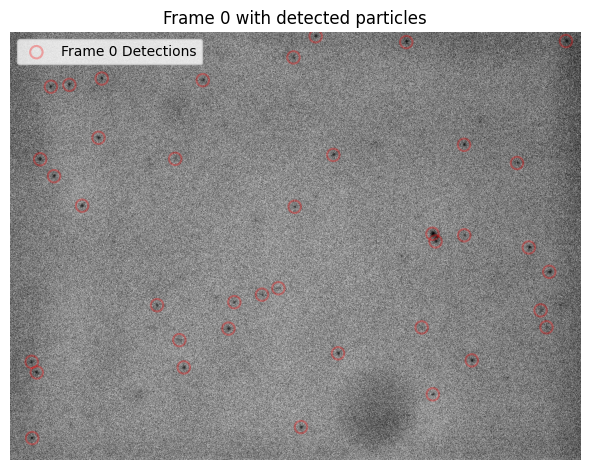

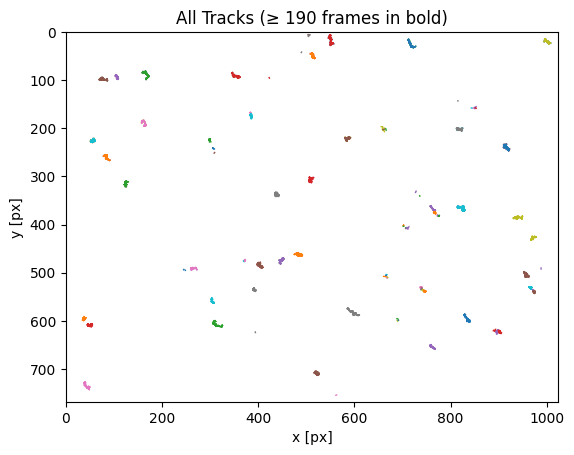

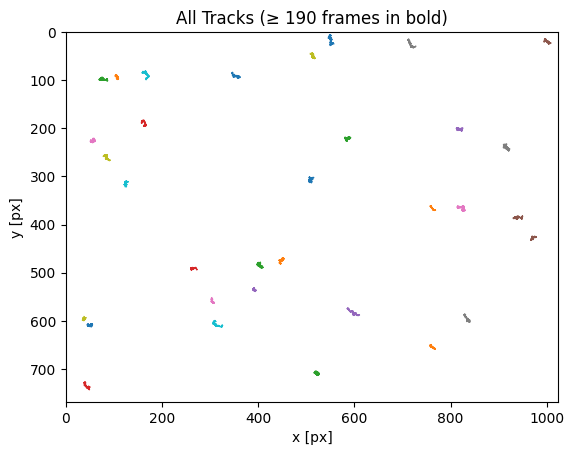

Particles tracked for exactly 200 frames: 30
Particles tracked ≥190 and <200 frames: 3
Particles tracked <190 frames (excluded from long_tracks): 440


In [44]:
# === Load frames ===
frames = tifffile.imread("1um/10x 1um better 6.tif")
total_frames = len(frames)

# === Preprocess frames ===
from skimage import exposure, util

def preprocess_frame(frame):
    blurred = filters.gaussian(frame, sigma=1)
    background = filters.gaussian(frame, sigma=10)
    enhanced = frame - background
    # Convert to uint8 for CLAHE
    enhanced_uint8 = util.img_as_ubyte(exposure.rescale_intensity(enhanced))
    clahe = exposure.equalize_adapthist(enhanced_uint8, clip_limit=0.03)
    return clahe



processed_frames = [preprocess_frame(f) for f in frames]

# === Detect features ===
diameter = 13
minmass = 3
features = tp.batch(processed_frames, diameter=diameter, minmass=minmass, threshold=0.005, invert=True)

# === Link particles ===
search_range = 10
memory = 5
linked = tp.link_df(features, search_range=search_range, memory=memory)

# === Enhanced Track Merging ===
def smart_merge_tracks(df, max_dist=30, max_gap=50, min_total_frames=0.95):
    df = df.sort_values(['particle', 'frame']).copy()
    particle_groups = df.groupby('particle')
    endpoints = []

    for pid, group in particle_groups:
        frames_tracked = group['frame'].nunique()
        start_frame = group['frame'].min()
        end_frame = group['frame'].max()
        start_pos = group[group['frame'] == start_frame][['x', 'y']].values[0]
        end_pos = group[group['frame'] == end_frame][['x', 'y']].values[0]
        endpoints.append({
            'particle': pid,
            'start': start_frame,
            'end': end_frame,
            'start_pos': start_pos,
            'end_pos': end_pos,
            'length': frames_tracked
        })

    used = set()
    merged_tracks = []
    new_particle_id = 0

    for i, pi in enumerate(endpoints):
        if pi['particle'] in used:
            continue

        candidate_ids = [pi['particle']]
        total_len = pi['length']
        used.add(pi['particle'])

        for j, pj in enumerate(endpoints):
            if pj['particle'] in used or pj['particle'] == pi['particle']:
                continue

            # Case 1: pj starts shortly after pi ends
            gap_forward = pj['start'] - pi['end']
            dist_forward = np.linalg.norm(pi['end_pos'] - pj['start_pos'])

            # Case 2: pj ends shortly before pi starts
            gap_backward = pi['start'] - pj['end']
            dist_backward = np.linalg.norm(pi['start_pos'] - pj['end_pos'])

            if (0 < gap_forward <= max_gap and dist_forward <= max_dist) or \
               (0 < gap_backward <= max_gap and dist_backward <= max_dist):

                combined_len = total_len + pj['length']
                if combined_len >= min_total_frames * total_frames:
                    candidate_ids.append(pj['particle'])
                    used.add(pj['particle'])
                    total_len = combined_len

        merged_df = df[df['particle'].isin(candidate_ids)].copy()
        merged_df['particle'] = new_particle_id
        merged_tracks.append(merged_df)
        new_particle_id += 1

    merged_all = pd.concat(merged_tracks, ignore_index=True)
    merged_all = merged_all.drop_duplicates(subset=['particle', 'frame'], keep='first')
    return merged_all


# === Merge smartly ===
linked_merged = smart_merge_tracks(linked, max_dist=30, max_gap=50, min_total_frames=0.95)


# === Filter: particles tracked for at least 95% of total frames ===
min_frames = int(0.95 * total_frames)
long_tracks = tp.filter_stubs(linked_merged, threshold=min_frames)
tracks_200_6 = linked_merged.groupby('particle').filter(lambda x: len(x) == 200)

# === Show lifespans ===
print("\nTrack durations (frames):")
print(linked_merged.groupby('particle').size().sort_values(ascending=False))


#Image
frame_index = 0
frame = frames[frame_index]
processed = preprocess_frame(frame)

# Filter features for just frame 0
features_frame0 = features[features['frame'] == frame_index]

fig, ax = plt.subplots()
ax.imshow(processed, cmap='gray')

# Transparent red circles
ax.scatter(features_frame0['x'], features_frame0['y'],
           facecolors='none', edgecolors='red', s=80,
           linewidth=1.5, alpha=0.3, label='Frame 0 Detections')

ax.set_title(f"Frame {frame_index} with detected particles")
ax.axis('off')
plt.legend()
plt.tight_layout()
plt.show()



#Map of every motion detection
fig, ax = plt.subplots()
tp.plot_traj(linked_merged, ax=ax, color='gray', alpha=0.3)   # all tracks
tp.plot_traj(long_tracks, ax=ax, lw=2)                        # long-lived bold

plt.xlim(0, frames[0].shape[1])     # width
plt.ylim(frames[0].shape[0], 0)     # full height
plt.gca().set_aspect('equal')
plt.title(f"All Tracks (≥ {min_frames} frames in bold)")
plt.show()

#Map of only particle motion detection
fig, ax = plt.subplots()
tp.plot_traj(long_tracks, ax=ax, lw=2)                        # long-lived bold

# === Fix y-axis and aspect ===
plt.xlim(0, frames[0].shape[1])     # width
plt.ylim(frames[0].shape[0], 0)     # full height
plt.gca().set_aspect('equal')
plt.title(f"All Tracks (≥ {min_frames} frames in bold)")
plt.show()

# Get total number of frames (should be 200 in your case)
total_frames = 200
long_threshold = int(0.95 * total_frames)  # e.g., 190

# Step 1: Compute track lengths from linked_merged
track_lengths = linked_merged.groupby('particle')['frame'].nunique()

# Step 2: Full 200-frame particles
full_200 = track_lengths[track_lengths == total_frames]

# Step 3: Long-lived particles that passed threshold but not 200
long_but_not_200 = track_lengths[(track_lengths >= long_threshold) & (track_lengths < total_frames)]

# Step 4: Particles that did not pass the 95% threshold (i.e., not in long_tracks)
all_particles = set(linked_merged['particle'].unique())
long_tracked_particles = set(long_tracks['particle'].unique())
short_lived_particles = all_particles - long_tracked_particles

# Print results
print(f"Particles tracked for exactly 200 frames: {len(full_200)}")
print(f"Particles tracked ≥{long_threshold} and <200 frames: {len(long_but_not_200)}")
print(f"Particles tracked <{long_threshold} frames (excluded from long_tracks): {len(short_lived_particles)}")


<h5>Run 7<h5>

Frame 199: 39 trajectories present.

Track durations (frames):
particle
11     200
22     200
20     200
24     200
18     200
      ... 
172      1
171      1
170      1
169      1
423      1
Length: 424, dtype: int64


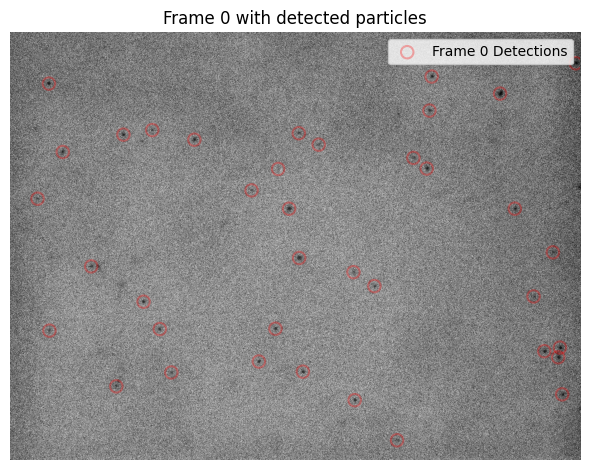

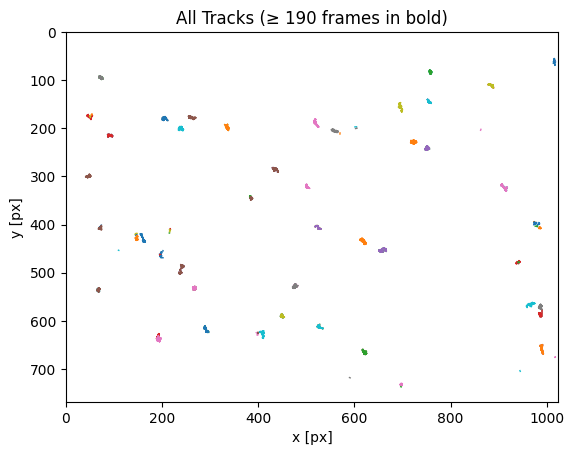

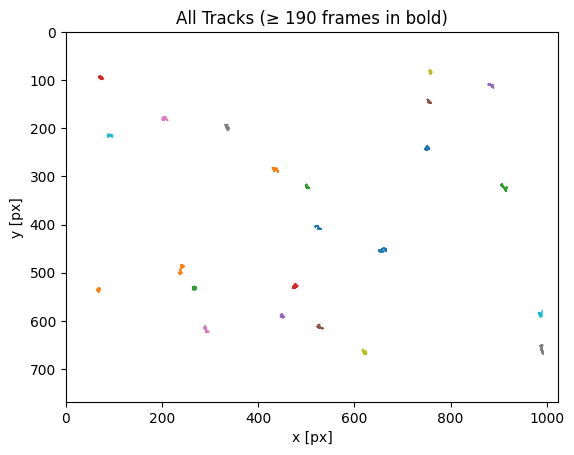

Particles tracked for exactly 200 frames: 21
Particles tracked ≥190 and <200 frames: 2
Particles tracked <190 frames (excluded from long_tracks): 401


In [45]:
# === Load frames ===
frames = tifffile.imread("1um/10x 1um better 7.tif")
total_frames = len(frames)

# === Preprocess frames ===
from skimage import exposure, util

def preprocess_frame(frame):
    blurred = filters.gaussian(frame, sigma=1)
    background = filters.gaussian(frame, sigma=10)
    enhanced = frame - background
    # Convert to uint8 for CLAHE
    enhanced_uint8 = util.img_as_ubyte(exposure.rescale_intensity(enhanced))
    clahe = exposure.equalize_adapthist(enhanced_uint8, clip_limit=0.03)
    return clahe



processed_frames = [preprocess_frame(f) for f in frames]

# === Detect features ===
diameter = 13
minmass = 3
features = tp.batch(processed_frames, diameter=diameter, minmass=minmass, threshold=0.005, invert=True)

# === Link particles ===
search_range = 10
memory = 5
linked = tp.link_df(features, search_range=search_range, memory=memory)

# === Enhanced Track Merging ===
def smart_merge_tracks(df, max_dist=30, max_gap=50, min_total_frames=0.95):
    df = df.sort_values(['particle', 'frame']).copy()
    particle_groups = df.groupby('particle')
    endpoints = []

    for pid, group in particle_groups:
        frames_tracked = group['frame'].nunique()
        start_frame = group['frame'].min()
        end_frame = group['frame'].max()
        start_pos = group[group['frame'] == start_frame][['x', 'y']].values[0]
        end_pos = group[group['frame'] == end_frame][['x', 'y']].values[0]
        endpoints.append({
            'particle': pid,
            'start': start_frame,
            'end': end_frame,
            'start_pos': start_pos,
            'end_pos': end_pos,
            'length': frames_tracked
        })

    used = set()
    merged_tracks = []
    new_particle_id = 0

    for i, pi in enumerate(endpoints):
        if pi['particle'] in used:
            continue

        candidate_ids = [pi['particle']]
        total_len = pi['length']
        used.add(pi['particle'])

        for j, pj in enumerate(endpoints):
            if pj['particle'] in used or pj['particle'] == pi['particle']:
                continue

            # Case 1: pj starts shortly after pi ends
            gap_forward = pj['start'] - pi['end']
            dist_forward = np.linalg.norm(pi['end_pos'] - pj['start_pos'])

            # Case 2: pj ends shortly before pi starts
            gap_backward = pi['start'] - pj['end']
            dist_backward = np.linalg.norm(pi['start_pos'] - pj['end_pos'])

            if (0 < gap_forward <= max_gap and dist_forward <= max_dist) or \
               (0 < gap_backward <= max_gap and dist_backward <= max_dist):

                combined_len = total_len + pj['length']
                if combined_len >= min_total_frames * total_frames:
                    candidate_ids.append(pj['particle'])
                    used.add(pj['particle'])
                    total_len = combined_len

        merged_df = df[df['particle'].isin(candidate_ids)].copy()
        merged_df['particle'] = new_particle_id
        merged_tracks.append(merged_df)
        new_particle_id += 1

    merged_all = pd.concat(merged_tracks, ignore_index=True)
    merged_all = merged_all.drop_duplicates(subset=['particle', 'frame'], keep='first')
    return merged_all


# === Merge smartly ===
linked_merged = smart_merge_tracks(linked, max_dist=30, max_gap=50, min_total_frames=0.95)


# === Filter: particles tracked for at least 95% of total frames ===
min_frames = int(0.95 * total_frames)
long_tracks = tp.filter_stubs(linked_merged, threshold=min_frames)
tracks_200_7 = linked_merged.groupby('particle').filter(lambda x: len(x) == 200)

# === Show lifespans ===
print("\nTrack durations (frames):")
print(linked_merged.groupby('particle').size().sort_values(ascending=False))


#Image
frame_index = 0
frame = frames[frame_index]
processed = preprocess_frame(frame)

# Filter features for just frame 0
features_frame0 = features[features['frame'] == frame_index]

fig, ax = plt.subplots()
ax.imshow(processed, cmap='gray')

# Transparent red circles
ax.scatter(features_frame0['x'], features_frame0['y'],
           facecolors='none', edgecolors='red', s=80,
           linewidth=1.5, alpha=0.3, label='Frame 0 Detections')

ax.set_title(f"Frame {frame_index} with detected particles")
ax.axis('off')
plt.legend()
plt.tight_layout()
plt.show()



#Map of every motion detection
fig, ax = plt.subplots()
tp.plot_traj(linked_merged, ax=ax, color='gray', alpha=0.3)   # all tracks
tp.plot_traj(long_tracks, ax=ax, lw=2)                        # long-lived bold

plt.xlim(0, frames[0].shape[1])     # width
plt.ylim(frames[0].shape[0], 0)     # full height
plt.gca().set_aspect('equal')
plt.title(f"All Tracks (≥ {min_frames} frames in bold)")
plt.show()

#Map of only particle motion detection
fig, ax = plt.subplots()
tp.plot_traj(long_tracks, ax=ax, lw=2)                        # long-lived bold

# === Fix y-axis and aspect ===
plt.xlim(0, frames[0].shape[1])     # width
plt.ylim(frames[0].shape[0], 0)     # full height
plt.gca().set_aspect('equal')
plt.title(f"All Tracks (≥ {min_frames} frames in bold)")
plt.show()

# Get total number of frames (should be 200 in your case)
total_frames = 200
long_threshold = int(0.95 * total_frames)  # e.g., 190

# Step 1: Compute track lengths from linked_merged
track_lengths = linked_merged.groupby('particle')['frame'].nunique()

# Step 2: Full 200-frame particles
full_200 = track_lengths[track_lengths == total_frames]

# Step 3: Long-lived particles that passed threshold but not 200
long_but_not_200 = track_lengths[(track_lengths >= long_threshold) & (track_lengths < total_frames)]

# Step 4: Particles that did not pass the 95% threshold (i.e., not in long_tracks)
all_particles = set(linked_merged['particle'].unique())
long_tracked_particles = set(long_tracks['particle'].unique())
short_lived_particles = all_particles - long_tracked_particles

# Print results
print(f"Particles tracked for exactly 200 frames: {len(full_200)}")
print(f"Particles tracked ≥{long_threshold} and <200 frames: {len(long_but_not_200)}")
print(f"Particles tracked <{long_threshold} frames (excluded from long_tracks): {len(short_lived_particles)}")


<h5>Run 8<h5>

Frame 199: 43 trajectories present.

Track durations (frames):
particle
30     200
28     200
26     200
25     200
31     200
      ... 
254      1
253      1
252      1
251      1
658      1
Length: 659, dtype: int64


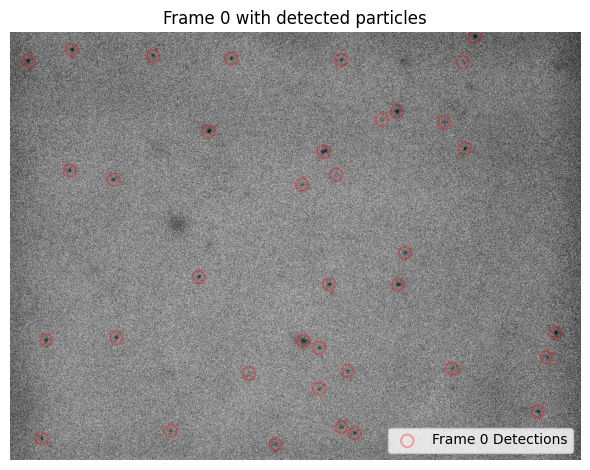

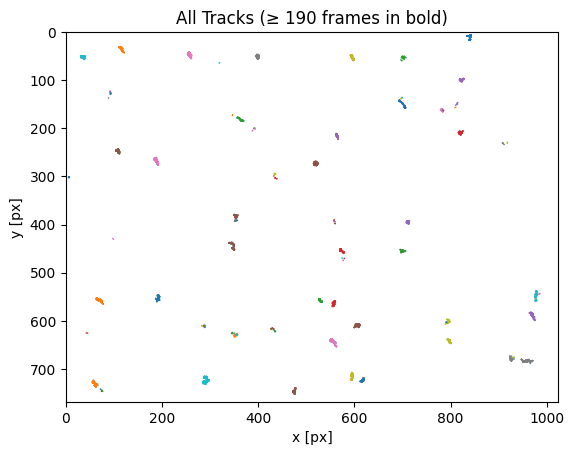

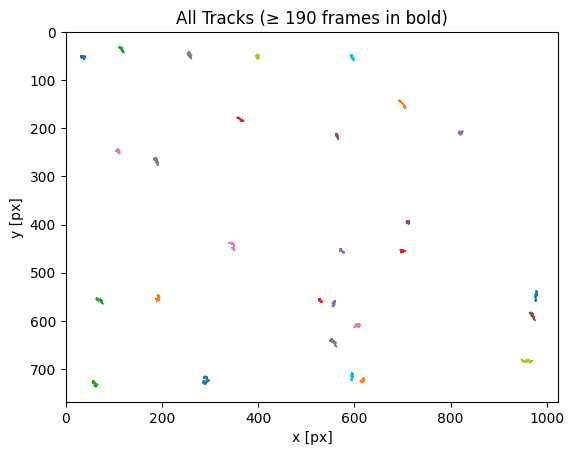

Particles tracked for exactly 200 frames: 26
Particles tracked ≥190 and <200 frames: 2
Particles tracked <190 frames (excluded from long_tracks): 631


In [46]:
# === Load frames ===
frames = tifffile.imread("1um/10x 1um better 8.tif")
total_frames = len(frames)

# === Preprocess frames ===
from skimage import exposure, util

def preprocess_frame(frame):
    blurred = filters.gaussian(frame, sigma=1)
    background = filters.gaussian(frame, sigma=10)
    enhanced = frame - background
    # Convert to uint8 for CLAHE
    enhanced_uint8 = util.img_as_ubyte(exposure.rescale_intensity(enhanced))
    clahe = exposure.equalize_adapthist(enhanced_uint8, clip_limit=0.03)
    return clahe



processed_frames = [preprocess_frame(f) for f in frames]

# === Detect features ===
diameter = 13
minmass = 3
features = tp.batch(processed_frames, diameter=diameter, minmass=minmass, threshold=0.005, invert=True)

# === Link particles ===
search_range = 10
memory = 5
linked = tp.link_df(features, search_range=search_range, memory=memory)

# === Enhanced Track Merging ===
def smart_merge_tracks(df, max_dist=30, max_gap=50, min_total_frames=0.95):
    df = df.sort_values(['particle', 'frame']).copy()
    particle_groups = df.groupby('particle')
    endpoints = []

    for pid, group in particle_groups:
        frames_tracked = group['frame'].nunique()
        start_frame = group['frame'].min()
        end_frame = group['frame'].max()
        start_pos = group[group['frame'] == start_frame][['x', 'y']].values[0]
        end_pos = group[group['frame'] == end_frame][['x', 'y']].values[0]
        endpoints.append({
            'particle': pid,
            'start': start_frame,
            'end': end_frame,
            'start_pos': start_pos,
            'end_pos': end_pos,
            'length': frames_tracked
        })

    used = set()
    merged_tracks = []
    new_particle_id = 0

    for i, pi in enumerate(endpoints):
        if pi['particle'] in used:
            continue

        candidate_ids = [pi['particle']]
        total_len = pi['length']
        used.add(pi['particle'])

        for j, pj in enumerate(endpoints):
            if pj['particle'] in used or pj['particle'] == pi['particle']:
                continue

            # Case 1: pj starts shortly after pi ends
            gap_forward = pj['start'] - pi['end']
            dist_forward = np.linalg.norm(pi['end_pos'] - pj['start_pos'])

            # Case 2: pj ends shortly before pi starts
            gap_backward = pi['start'] - pj['end']
            dist_backward = np.linalg.norm(pi['start_pos'] - pj['end_pos'])

            if (0 < gap_forward <= max_gap and dist_forward <= max_dist) or \
               (0 < gap_backward <= max_gap and dist_backward <= max_dist):

                combined_len = total_len + pj['length']
                if combined_len >= min_total_frames * total_frames:
                    candidate_ids.append(pj['particle'])
                    used.add(pj['particle'])
                    total_len = combined_len

        merged_df = df[df['particle'].isin(candidate_ids)].copy()
        merged_df['particle'] = new_particle_id
        merged_tracks.append(merged_df)
        new_particle_id += 1

    merged_all = pd.concat(merged_tracks, ignore_index=True)
    merged_all = merged_all.drop_duplicates(subset=['particle', 'frame'], keep='first')
    return merged_all


# === Merge smartly ===
linked_merged = smart_merge_tracks(linked, max_dist=30, max_gap=50, min_total_frames=0.95)


# === Filter: particles tracked for at least 95% of total frames ===
min_frames = int(0.95 * total_frames)
long_tracks = tp.filter_stubs(linked_merged, threshold=min_frames)
tracks_200_8 = linked_merged.groupby('particle').filter(lambda x: len(x) == 200)

# === Show lifespans ===
print("\nTrack durations (frames):")
print(linked_merged.groupby('particle').size().sort_values(ascending=False))


#Image
frame_index = 0
frame = frames[frame_index]
processed = preprocess_frame(frame)

# Filter features for just frame 0
features_frame0 = features[features['frame'] == frame_index]

fig, ax = plt.subplots()
ax.imshow(processed, cmap='gray')

# Transparent red circles
ax.scatter(features_frame0['x'], features_frame0['y'],
           facecolors='none', edgecolors='red', s=80,
           linewidth=1.5, alpha=0.3, label='Frame 0 Detections')

ax.set_title(f"Frame {frame_index} with detected particles")
ax.axis('off')
plt.legend()
plt.tight_layout()
plt.show()



#Map of every motion detection
fig, ax = plt.subplots()
tp.plot_traj(linked_merged, ax=ax, color='gray', alpha=0.3)   # all tracks
tp.plot_traj(long_tracks, ax=ax, lw=2)                        # long-lived bold

plt.xlim(0, frames[0].shape[1])     # width
plt.ylim(frames[0].shape[0], 0)     # full height
plt.gca().set_aspect('equal')
plt.title(f"All Tracks (≥ {min_frames} frames in bold)")
plt.show()

#Map of only particle motion detection
fig, ax = plt.subplots()
tp.plot_traj(long_tracks, ax=ax, lw=2)                        # long-lived bold

# === Fix y-axis and aspect ===
plt.xlim(0, frames[0].shape[1])     # width
plt.ylim(frames[0].shape[0], 0)     # full height
plt.gca().set_aspect('equal')
plt.title(f"All Tracks (≥ {min_frames} frames in bold)")
plt.show()

# Get total number of frames (should be 200 in your case)
total_frames = 200
long_threshold = int(0.95 * total_frames)  # e.g., 190

# Step 1: Compute track lengths from linked_merged
track_lengths = linked_merged.groupby('particle')['frame'].nunique()

# Step 2: Full 200-frame particles
full_200 = track_lengths[track_lengths == total_frames]

# Step 3: Long-lived particles that passed threshold but not 200
long_but_not_200 = track_lengths[(track_lengths >= long_threshold) & (track_lengths < total_frames)]

# Step 4: Particles that did not pass the 95% threshold (i.e., not in long_tracks)
all_particles = set(linked_merged['particle'].unique())
long_tracked_particles = set(long_tracks['particle'].unique())
short_lived_particles = all_particles - long_tracked_particles

# Print results
print(f"Particles tracked for exactly 200 frames: {len(full_200)}")
print(f"Particles tracked ≥{long_threshold} and <200 frames: {len(long_but_not_200)}")
print(f"Particles tracked <{long_threshold} frames (excluded from long_tracks): {len(short_lived_particles)}")


<h5>Run 9<h5>

Frame 199: 48 trajectories present.

Track durations (frames):
particle
0      200
22     200
20     200
18     200
25     200
      ... 
307      1
308      1
309      1
311      1
759      1
Length: 760, dtype: int64


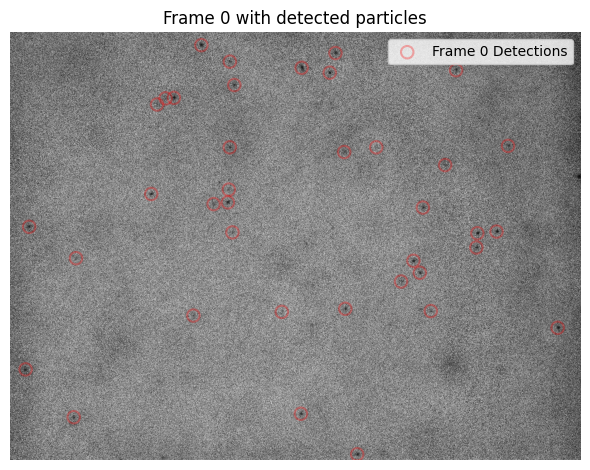

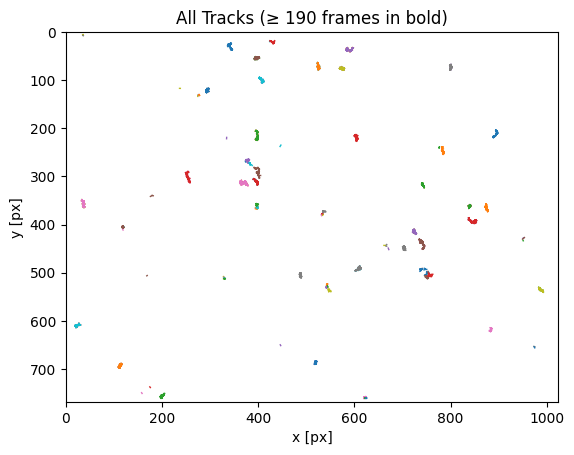

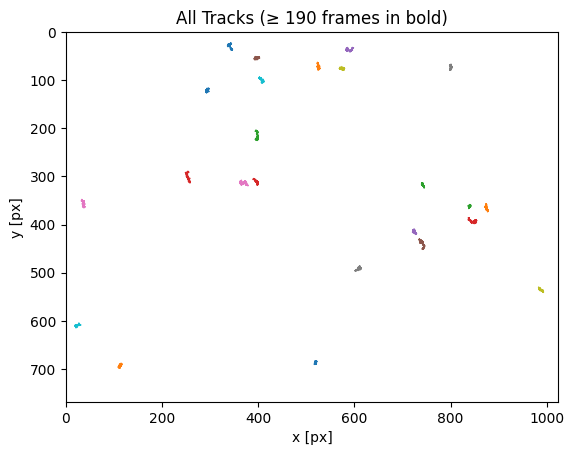

Particles tracked for exactly 200 frames: 21
Particles tracked ≥190 and <200 frames: 3
Particles tracked <190 frames (excluded from long_tracks): 736


In [ ]:
# === Load frames ===
frames = tifffile.imread("1um/10x 1um better 9.tif")
total_frames = len(frames)

# === Preprocess frames ===
from skimage import exposure, util

def preprocess_frame(frame):
    blurred = filters.gaussian(frame, sigma=1)
    background = filters.gaussian(frame, sigma=10)
    enhanced = frame - background
    # Convert to uint8 for CLAHE
    enhanced_uint8 = util.img_as_ubyte(exposure.rescale_intensity(enhanced))
    clahe = exposure.equalize_adapthist(enhanced_uint8, clip_limit=0.03)
    return clahe



processed_frames = [preprocess_frame(f) for f in frames]

# === Detect features ===
diameter = 13
minmass = 3
features = tp.batch(processed_frames, diameter=diameter, minmass=minmass, threshold=0.005, invert=True)

# === Link particles ===
search_range = 10
memory = 5
linked = tp.link_df(features, search_range=search_range, memory=memory)

# === Enhanced Track Merging ===
def smart_merge_tracks(df, max_dist=30, max_gap=50, min_total_frames=0.95):
    df = df.sort_values(['particle', 'frame']).copy()
    particle_groups = df.groupby('particle')
    endpoints = []

    for pid, group in particle_groups:
        frames_tracked = group['frame'].nunique()
        start_frame = group['frame'].min()
        end_frame = group['frame'].max()
        start_pos = group[group['frame'] == start_frame][['x', 'y']].values[0]
        end_pos = group[group['frame'] == end_frame][['x', 'y']].values[0]
        endpoints.append({
            'particle': pid,
            'start': start_frame,
            'end': end_frame,
            'start_pos': start_pos,
            'end_pos': end_pos,
            'length': frames_tracked
        })

    used = set()
    merged_tracks = []
    new_particle_id = 0

    for i, pi in enumerate(endpoints):
        if pi['particle'] in used:
            continue

        candidate_ids = [pi['particle']]
        total_len = pi['length']
        used.add(pi['particle'])

        for j, pj in enumerate(endpoints):
            if pj['particle'] in used or pj['particle'] == pi['particle']:
                continue

            # Case 1: pj starts shortly after pi ends
            gap_forward = pj['start'] - pi['end']
            dist_forward = np.linalg.norm(pi['end_pos'] - pj['start_pos'])

            # Case 2: pj ends shortly before pi starts
            gap_backward = pi['start'] - pj['end']
            dist_backward = np.linalg.norm(pi['start_pos'] - pj['end_pos'])

            if (0 < gap_forward <= max_gap and dist_forward <= max_dist) or \
               (0 < gap_backward <= max_gap and dist_backward <= max_dist):

                combined_len = total_len + pj['length']
                if combined_len >= min_total_frames * total_frames:
                    candidate_ids.append(pj['particle'])
                    used.add(pj['particle'])
                    total_len = combined_len

        merged_df = df[df['particle'].isin(candidate_ids)].copy()
        merged_df['particle'] = new_particle_id
        merged_tracks.append(merged_df)
        new_particle_id += 1

    merged_all = pd.concat(merged_tracks, ignore_index=True)
    merged_all = merged_all.drop_duplicates(subset=['particle', 'frame'], keep='first')
    return merged_all


# === Merge smartly ===
linked_merged = smart_merge_tracks(linked, max_dist=30, max_gap=50, min_total_frames=0.95)


# === Filter: particles tracked for at least 95% of total frames ===
min_frames = int(0.95 * total_frames)
long_tracks = tp.filter_stubs(linked_merged, threshold=min_frames)
tracks_200_9 = linked_merged.groupby('particle').filter(lambda x: len(x) == 200)

# === Show lifespans ===
print("\nTrack durations (frames):")
print(linked_merged.groupby('particle').size().sort_values(ascending=False))


#Image
frame_index = 0
frame = frames[frame_index]
processed = preprocess_frame(frame)

# Filter features for just frame 0
features_frame0 = features[features['frame'] == frame_index]

fig, ax = plt.subplots()
ax.imshow(processed, cmap='gray')

# Transparent red circles
ax.scatter(features_frame0['x'], features_frame0['y'],
           facecolors='none', edgecolors='red', s=80,
           linewidth=1.5, alpha=0.3, label='Frame 0 Detections')

ax.set_title(f"Frame {frame_index} with detected particles")
ax.axis('off')
plt.legend()
plt.tight_layout()
plt.show()



#Map of every motion detection
fig, ax = plt.subplots()
tp.plot_traj(linked_merged, ax=ax, color='gray', alpha=0.3)   # all tracks
tp.plot_traj(long_tracks, ax=ax, lw=2)                        # long-lived bold

plt.xlim(0, frames[0].shape[1])     # width
plt.ylim(frames[0].shape[0], 0)     # full height
plt.gca().set_aspect('equal')
plt.title(f"All Tracks (≥ {min_frames} frames in bold)")
plt.show()

#Map of only particle motion detection
fig, ax = plt.subplots()
tp.plot_traj(long_tracks, ax=ax, lw=2)                        # long-lived bold

# === Fix y-axis and aspect ===
plt.xlim(0, frames[0].shape[1])     # width
plt.ylim(frames[0].shape[0], 0)     # full height
plt.gca().set_aspect('equal')
plt.title(f"All Tracks (≥ {min_frames} frames in bold)")
plt.show()

# Get total number of frames (should be 200 in your case)
total_frames = 200
long_threshold = int(0.95 * total_frames)  # e.g., 190

# Step 1: Compute track lengths from linked_merged
track_lengths = linked_merged.groupby('particle')['frame'].nunique()

# Step 2: Full 200-frame particles
full_200 = track_lengths[track_lengths == total_frames]

# Step 3: Long-lived particles that passed threshold but not 200
long_but_not_200 = track_lengths[(track_lengths >= long_threshold) & (track_lengths < total_frames)]

# Step 4: Particles that did not pass the 95% threshold (i.e., not in long_tracks)
all_particles = set(linked_merged['particle'].unique())
long_tracked_particles = set(long_tracks['particle'].unique())
short_lived_particles = all_particles - long_tracked_particles

# Print results
print(f"Particles tracked for exactly 200 frames: {len(full_200)}")
print(f"Particles tracked ≥{long_threshold} and <200 frames: {len(long_but_not_200)}")
print(f"Particles tracked <{long_threshold} frames (excluded from long_tracks): {len(short_lived_particles)}")


Rayleigh fit scale parameter σ_r = 0.3016 μm
Estimated diffusion coefficient D = 1.0728e+00 μm²/s


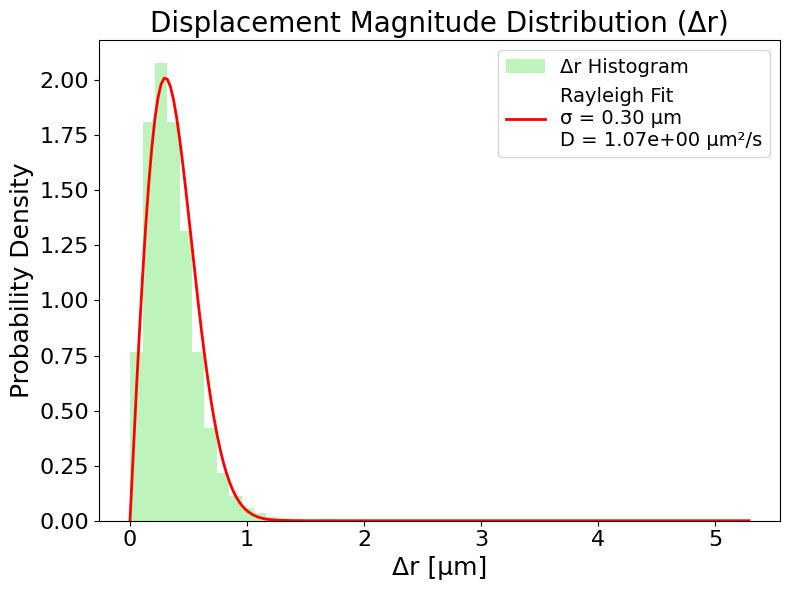

In [ ]:
import pandas as pd

# Suppose you have your tracks dataframes in a list:
all_tracks = [tracks_200_1, tracks_200_2, tracks_200_3, tracks_200_4, 
              tracks_200_5, tracks_200_6, tracks_200_7, tracks_200_8, tracks_200_9]

# Initialize empty list for adjusted dataframes
adjusted_tracks = []

# Running particle ID offset
pid_offset = 0

for trial_index, df in enumerate(all_tracks, start=1):
    df_copy = df.copy()
    # Add trial number column (optional but helpful)
    df_copy['trial'] = trial_index
    
    # Shift particle IDs by current offset
    df_copy['particle'] = df_copy['particle'] + pid_offset
    
    # Update offset for next trial
    max_pid = df_copy['particle'].max()
    pid_offset = max_pid + 1
    
    adjusted_tracks.append(df_copy)

# Concatenate all trials into one dataframe
tracks_all = pd.concat(adjusted_tracks, ignore_index=True)

import matplotlib.pyplot as plt
from scipy.stats import norm

# === 1. Find 200-frame particles from combined tracks ===
track_lengths = tracks_all.groupby('particle')['frame'].nunique()
full_200_ids = track_lengths[track_lengths == 200].index
full_200 = tracks_all[tracks_all['particle'].isin(full_200_ids)]


Δx: σ = 0.2619 ± 0.0009 μm
    D = 5.1500e-01 ± 3.4044e-03 μm²/s
    k_B = 1.6334e-23 ± 1.0798e-25 J/K

Δy: σ = 0.3358 ± 0.0011 μm
    D = 8.4686e-01 ± 5.5981e-03 μm²/s
    k_B = 2.6860e-23 ± 1.7756e-25 J/K

Δr: σ_r = 0.3016 ± 0.0010 μm
    D = 1.0728e+00 ± 7.0915e-03 μm²/s
    k_B = 3.4026e-23 ± 2.2492e-25 J/K


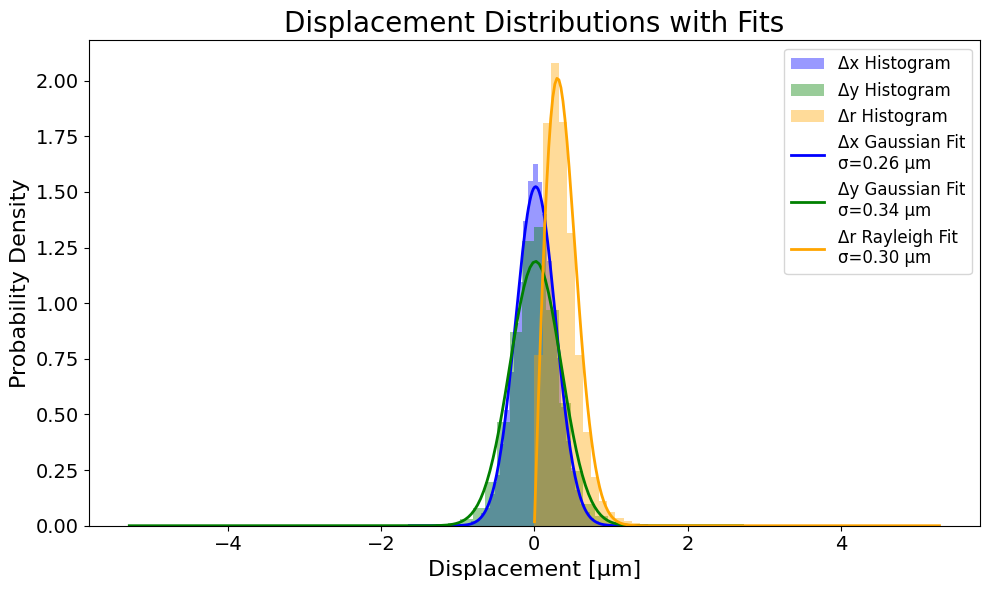

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, rayleigh

# Constants for Boltzmann calculation
eta = 0.001       # Dynamic viscosity of water (Pa·s)
r_particle = 0.5e-6  # radius in meters (0.5 micron)
T = 297.15        # temperature in K
fps = 15.02       # frames per second (adjust if different)
delta_t = 1 / fps

# Your microns_per_pixel calibration
microns_per_pixel = 0.4681645887845223

# Data preparation: assume full_200 is your dataframe of particles tracked full 200 frames

# Extract displacements
dx_all = []
dy_all = []
dr_all = []

for pid, group in full_200.groupby('particle'):
    group = group.sort_values('frame').reset_index(drop=True)
    dx = group['x'].diff().dropna()
    dy = group['y'].diff().dropna()
    dr = np.sqrt(dx**2 + dy**2)
    dx_all.extend(dx)
    dy_all.extend(dy)
    dr_all.extend(dr)

# Convert to microns
dx_all = np.array(dx_all) * microns_per_pixel
dy_all = np.array(dy_all) * microns_per_pixel
dr_all = np.array(dr_all) * microns_per_pixel

n_dx = len(dx_all)
n_dy = len(dy_all)
n_dr = len(dr_all)

# --- Gaussian fit for dx ---
mu_x, std_x = norm.fit(dx_all)
# Standard error of std dev (approx)
std_x_err = std_x / np.sqrt(2 * (n_dx - 1))

# Diffusion coefficient from variance: D = σ² / (2 Δt)
D_x = std_x**2 / (2 * delta_t)
D_x_err = (2 * std_x * std_x_err) / (2 * delta_t)  # error propagation

# --- Gaussian fit for dy ---
mu_y, std_y = norm.fit(dy_all)
std_y_err = std_y / np.sqrt(2 * (n_dy - 1))
D_y = std_y**2 / (2 * delta_t)
D_y_err = (2 * std_y * std_y_err) / (2 * delta_t)

# --- Rayleigh fit for dr ---
params_r = rayleigh.fit(dr_all, floc=0)
scale_r = params_r[1]
# Error approx for Rayleigh scale
scale_r_err = scale_r / np.sqrt(2 * n_dr)

# Diffusion from Rayleigh scale (using: D = σ² * π / (4 Δt))
D_r = (scale_r**2 * np.pi) / (4 * delta_t)
D_r_err = (2 * scale_r * scale_r_err * np.pi) / (4 * delta_t)

# --- Boltzmann constant from each D ---
kB_x = 6 * np.pi * eta * r_particle * D_x * 1e-12 / T  # convert D µm²/s to m²/s by 1e-12
kB_x_err = kB_x * (D_x_err / D_x)

kB_y = 6 * np.pi * eta * r_particle * D_y * 1e-12 / T
kB_y_err = kB_y * (D_y_err / D_y)

kB_r = 6 * np.pi * eta * r_particle * D_r * 1e-12 / T
kB_r_err = kB_r * (D_r_err / D_r)

# --- Print results ---
print(f"Δx: σ = {std_x:.4f} ± {std_x_err:.4f} μm")
print(f"    D = {D_x:.4e} ± {D_x_err:.4e} μm²/s")
print(f"    k_B = {kB_x:.4e} ± {kB_x_err:.4e} J/K\n")

print(f"Δy: σ = {std_y:.4f} ± {std_y_err:.4f} μm")
print(f"    D = {D_y:.4e} ± {D_y_err:.4e} μm²/s")
print(f"    k_B = {kB_y:.4e} ± {kB_y_err:.4e} J/K\n")

print(f"Δr: σ_r = {scale_r:.4f} ± {scale_r_err:.4f} μm")
print(f"    D = {D_r:.4e} ± {D_r_err:.4e} μm²/s")
print(f"    k_B = {kB_r:.4e} ± {kB_r_err:.4e} J/K")

# Optional: Return these for further use
results = {
    'Dx': (D_x, D_x_err, kB_x, kB_x_err),
    'Dy': (D_y, D_y_err, kB_y, kB_y_err),
    'Dr': (D_r, D_r_err, kB_r, kB_r_err)
}

fig, ax = plt.subplots(figsize=(10, 6))

# Histogram bins
bins = 50

# Plot histogram Δx
counts_x, bins_x, _ = ax.hist(dx_all, bins=bins, density=True, alpha=0.4, color='blue', label='Δx Histogram')

# Plot histogram Δy
counts_y, bins_y, _ = ax.hist(dy_all, bins=bins, density=True, alpha=0.4, color='green', label='Δy Histogram')

# Plot histogram Δr
counts_r, bins_r, _ = ax.hist(dr_all, bins=bins, density=True, alpha=0.4, color='orange', label='Δr Histogram')

# Fit Gaussians to Δx and Δy
mu_x, std_x = norm.fit(dx_all)
mu_y, std_y = norm.fit(dy_all)

# Fit Rayleigh to Δr (fix location=0)
params_r = rayleigh.fit(dr_all, floc=0)
scale_r = params_r[1]

# x values for fits
x_fit_x = np.linspace(bins_x[0], bins_x[-1], 200)
x_fit_y = np.linspace(bins_y[0], bins_y[-1], 200)
x_fit_r = np.linspace(bins_r[0], bins_r[-1], 200)

# PDF for fits
pdf_x = norm.pdf(x_fit_x, mu_x, std_x)
pdf_y = norm.pdf(x_fit_y, mu_y, std_y)
pdf_r = rayleigh.pdf(x_fit_r, loc=0, scale=scale_r)

# Plot fits
ax.plot(x_fit_x, pdf_x, 'b-', lw=2, label=f'Δx Gaussian Fit\nσ={std_x:.2f} μm')
ax.plot(x_fit_y, pdf_y, 'g-', lw=2, label=f'Δy Gaussian Fit\nσ={std_y:.2f} μm')
ax.plot(x_fit_r, pdf_r, 'orange', lw=2, label=f'Δr Rayleigh Fit\nσ={scale_r:.2f} μm')

# Labels & legend
ax.set_xlabel("Displacement [μm]", fontsize=16)
ax.set_ylabel("Probability Density", fontsize=16)
ax.set_title("Displacement Distributions with Fits", fontsize=20)
ax.legend(fontsize=12)
ax.tick_params(axis='both', labelsize=14)

plt.tight_layout()
plt.show()

In [48]:
microns_per_pixel = 100/221.1
microns_per_pixel = 0.4681645887845223
#mu m (since it's .1 mm between the two lines/pixels counted by the yellow line)

msd1 = tp.emsd(tracks_all, mpp=microns_per_pixel, fps=15.02)

from scipy.stats import linregress

# Use only the first ~10 lag times for linear fit
lag = msd1.index.values[:10]
displacement = msd1.values[:10]

slope, intercept, r_value, p_value, stderr = linregress(lag, displacement)
D = slope / 4
D_err = stderr / 4
print(f"Diffusion coefficient D = {D:.4e} µm²/s")
print(f"Diffusion error D_err = {D_err:.4e} µm²/s") 



eta = 0.001       # Pa·s for water
r = 0.5e-6        # 1 µm diameter = 0.5 µm radius = 0.5e-6 m
T = 297.15           # room temp (Kelvin)

k_B = 6 * np.pi * eta * r * D * 1e-12 / T  # D in µm²/s → m²/s = ×1e-12
k_B_err = k_B * (D_err / D)
print(f"Estimated Boltzmann constant k_B = {k_B:.4e} J/K")
print(f"Estimated Boltzmann error k_B_err = {k_B_err:.4e} J/K")

Diffusion coefficient D = 3.2995e-01 µm²/s
Diffusion error D_err = 7.4556e-03 µm²/s
Estimated Boltzmann constant k_B = 1.0465e-23 J/K
Estimated Boltzmann error k_B_err = 2.3647e-25 J/K


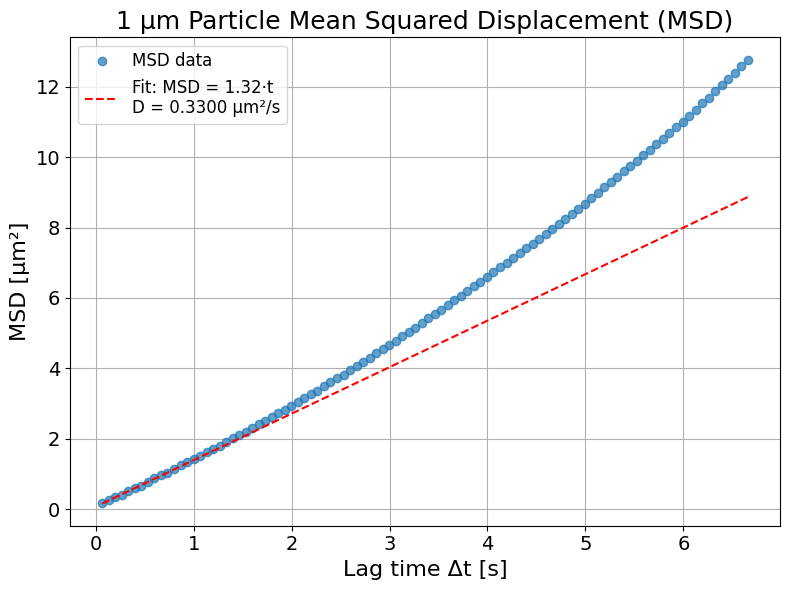

In [79]:
import matplotlib.pyplot as plt
from scipy.stats import linregress

# === Step 1: Extract values for linear fit ===
# Use first 10 points (small lags) for fit — pure Brownian motion
lag = msd1.index.values[:10]
displacement = msd1.values[:10]

# Linear regression: MSD = 4D * t  → D = slope / 4
slope, intercept, r_value, p_value, stderr = linregress(lag, displacement)
D = slope / 4
D_err = stderr / 4

# === Step 2: Make the plot ===
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title("1 µm Particle Mean Squared Displacement (MSD)", fontsize=18)

# Plot MSD curve
ax.plot(msd1.index, msd1.values, 'o', label='MSD data', alpha=0.7)

# Plot best-fit line
fit_line = slope * msd1.index + intercept
ax.plot(msd1.index, fit_line, 'r--', label=f'Fit: MSD = {slope:.2f}·t\nD = {D:.4f} µm²/s')

# Labels and aesthetics
ax.set_xlabel("Lag time Δt [s]", fontsize=16)
ax.set_ylabel("MSD [µm²]", fontsize=16)
ax.tick_params(axis='both', labelsize=14)
ax.legend(fontsize=12)
ax.grid(True)
plt.tight_layout()
plt.savefig('1mum MSD')
plt.show()


<h1>Boltzmann constant</h1>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io, color, filters, exposure, util
from scipy.stats import linregress
import trackpy as tp
import tifffile

# === Load frames ===
frames = tifffile.imread("2um/10x 2um better 1.tif")
total_frames = len(frames)

# === Preprocess frames ===
def preprocess_frame(frame):
    blurred = filters.gaussian(frame, sigma=1)
    background = filters.gaussian(frame, sigma=10)
    enhanced = frame - background
    enhanced_uint8 = util.img_as_ubyte(exposure.rescale_intensity(enhanced))
    clahe = exposure.equalize_adapthist(enhanced_uint8, clip_limit=0.03)
    return clahe

processed_frames = [preprocess_frame(f) for f in frames]

# === Detect features ===
diameter = 13
minmass = 3
features = tp.batch(processed_frames, diameter=diameter, minmass=minmass, threshold=0.005, invert=True)

# === Link particles ===
search_range = 10
memory = 5
linked = tp.link_df(features, search_range=search_range, memory=memory)

# === No merging of tracks, use linked as is ===
linked_merged = linked

# === Filter: particles tracked for at least 95% of total frames ===
min_frames = int(0.95 * total_frames)
long_tracks = tp.filter_stubs(linked_merged, threshold=min_frames)

print("\nTrack durations (frames):")
print(linked_merged.groupby('particle').size().sort_values(ascending=False))

# === Load ruler image and compute scale automatically ===
ruler_img = io.imread("10x ruler.jpg")
gray_ruler = color.rgb2gray(ruler_img)

edges = filters.sobel(gray_ruler)
coords = np.argwhere(edges > np.percentile(edges, 99.9))

y_min, x_min = coords.min(axis=0)
y_max, x_max = coords.max(axis=0)

pixel_distance = np.hypot(x_max - x_min, y_max - y_min)
real_distance_m = 2e-3  # 2 mm
meters_per_pixel = real_distance_m / pixel_distance

print(f"Estimated scale: {meters_per_pixel:.3e} meters/pixel (from diagonal 2 mm line)")

# === Convert pixel positions to meters ===
long_tracks['x_m'] = long_tracks['x'] * meters_per_pixel
long_tracks['y_m'] = long_tracks['y'] * meters_per_pixel

# Reset index *safely* by dropping only if needed
index_names = long_tracks.index.names
columns_to_drop = []

if 'frame' in index_names and 'frame' in long_tracks.columns:
    columns_to_drop.append('frame')
if 'particle' in index_names and 'particle' in long_tracks.columns:
    columns_to_drop.append('particle')

if columns_to_drop:
    long_tracks = long_tracks.drop(columns=columns_to_drop)

if 'frame' in index_names or 'particle' in index_names:
    long_tracks = long_tracks.reset_index()



# === Clean trajectories: remove broken trajectories with gaps in frames ===
long_tracks = long_tracks.sort_values(['particle', 'frame']).copy()
long_tracks['frame_diff'] = long_tracks.groupby('particle')['frame'].diff()
broken_ids = long_tracks[long_tracks['frame_diff'] > 1]['particle'].unique()
valid_tracks = long_tracks[~long_tracks['particle'].isin(broken_ids)].copy()

print(f"Removed {len(broken_ids)} broken trajectories. {valid_tracks['particle'].nunique()} valid remain.")

# === Relabel trajectories so each continuous segment per particle is unique ===
def relabel_trajectories(df):
    df = df.sort_values(['particle', 'frame']).copy()
    df['frame_diff'] = df.groupby('particle')['frame'].diff()
    df['new_traj'] = (df['frame_diff'] > 1).cumsum()
    df['particle'] = df['particle'].astype(str) + '_' + df['new_traj'].astype(str)
    unique_particles = {pid: i for i, pid in enumerate(df['particle'].unique())}
    df['particle'] = df['particle'].map(unique_particles)
    df = df.drop(columns=['frame_diff', 'new_traj'])
    return df

valid_tracks = relabel_trajectories(valid_tracks)

from trackpy.utils import _relabeller
valid_tracks = _relabeller().relabel_particles(valid_tracks)


# === Compute MSD ===
fps = 15  # frames per second, adjust as needed
msd = tp.motion.msd(valid_tracks, mpp=meters_per_pixel, fps=fps)

# === Fit MSD = 4Dt ===
msd_fit = msd.iloc[:10]  # Use first 10 points for fit
slope, intercept, r_value, p_value, std_err = linregress(msd_fit.index, msd_fit['msd'])
D = slope / 4
print(f"Estimated diffusion coefficient D = {D:.2e} m²/s")

# === Compute Boltzmann constant estimate ===
eta = 0.001  # viscosity of water, Pa·s
r = 2e-6     # particle radius in meters
T = 298      # temperature in K

k_B = D * 6 * np.pi * eta * r / T
print(f"Estimated Boltzmann constant k_B = {k_B:.2e} J/K")

# === Plot MSD and fit ===
plt.figure(figsize=(6,4))
plt.plot(msd.index, msd['msd'], label='MSD (m²)')
plt.plot(msd_fit.index, slope * msd_fit.index + intercept, 'r--', label='Linear fit to early MSD')
plt.xlabel('Time (s)')
plt.ylabel('MSD (m²)')
plt.legend()
plt.grid(True)
plt.title('Mean Squared Displacement')
plt.tight_layout()
plt.show()


Frame 199: 215 trajectories present.

Track durations (frames):
particle
0      200
177    200
109    200
107    200
105    200
      ... 
461      1
458      1
453      1
451      1
740      1
Length: 741, dtype: int64
Estimated scale: 1.679e-06 meters/pixel (from diagonal 2 mm line)
Removed 29 broken trajectories. 128 valid remain.


ImportError: cannot import name '_relabeller' from 'trackpy.utils' (/Users/virginia/anaconda3/lib/python3.10/site-packages/trackpy/utils.py)

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import linregress
from skimage import io, color, filters

# === Load ruler image and compute scale automatically ===
ruler_img = io.imread("10x ruler.jpg")
gray_ruler = color.rgb2gray(ruler_img)
edges = filters.sobel(gray_ruler)
coords = np.argwhere(edges > np.percentile(edges, 99.9))
y_min, x_min = coords.min(axis=0)
y_max, x_max = coords.max(axis=0)
pixel_distance = np.hypot(x_max - x_min, y_max - y_min)
real_distance_m = .5e-3  # 2 mm
meters_per_pixel = real_distance_m / pixel_distance
print(f"Estimated scale: {meters_per_pixel:.3e} meters/pixel (from diagonal 2 mm line)")

# === Convert pixel positions to meters ===
long_tracks['x_m'] = long_tracks['x'] * meters_per_pixel
long_tracks['y_m'] = long_tracks['y'] * meters_per_pixel

# === Fix duplicated index/column issue before reset_index ===
if ('frame' in long_tracks.index.names) or ('particle' in long_tracks.index.names):
    long_tracks = long_tracks.drop(columns=['frame', 'particle'], errors='ignore')
    long_tracks = long_tracks.reset_index()

# === Remove broken trajectories with gaps in frame numbers ===
long_tracks = long_tracks.sort_values(['particle', 'frame']).copy()
long_tracks['frame_diff'] = long_tracks.groupby('particle')['frame'].diff()
broken_ids = long_tracks[long_tracks['frame_diff'] > 1]['particle'].unique()
valid_tracks = long_tracks[~long_tracks['particle'].isin(broken_ids)].copy()
print(f"Removed {len(broken_ids)} broken trajectories. {valid_tracks['particle'].nunique()} valid remain.")

# === Relabel trajectories so each continuous segment per particle has unique particle ID ===
def relabel_trajectories(df):
    df = df.sort_values(['particle', 'frame']).copy()
    df['frame_diff'] = df.groupby('particle')['frame'].diff()
    df['new_traj'] = (df['frame_diff'] > 1).cumsum()
    df['particle'] = df['particle'].astype(str) + '_' + df['new_traj'].astype(str)
    unique_particles = {pid: i for i, pid in enumerate(df['particle'].unique())}
    df['particle'] = df['particle'].map(unique_particles)
    df = df.drop(columns=['frame_diff', 'new_traj'])
    return df

valid_tracks = relabel_trajectories(valid_tracks)

# === Compute MSD ===
fps = 15  # frames per second (adjust if needed)
msd = tp.motion.msd(valid_tracks, mpp=meters_per_pixel, fps=fps)

# === Fit MSD = 4Dt (linear fit to early points) ===
msd_fit = msd.iloc[:10]
slope, intercept, r_value, p_value, std_err = linregress(msd_fit.index, msd_fit['msd'])
D = slope / 4
print(f"Estimated diffusion coefficient D = {D:.2e} m²/s")

# === Estimate Boltzmann constant ===
eta = 0.001  # Pa·s, viscosity of water
r = 2e-6     # meters, particle radius
T = 298      # Kelvin

k_B = D * 6 * np.pi * eta * r / T
print(f"Estimated Boltzmann constant k_B = {k_B:.2e} J/K")

# === Plot MSD with fit line ===
plt.figure(figsize=(6,4))
plt.plot(msd.index, msd['msd'], label='MSD (m²)')
plt.plot(msd_fit.index, slope * msd_fit.index + intercept, 'r--', label='Linear fit to early MSD')
plt.xlabel('Time (s)')
plt.ylabel('MSD (m²)')
plt.legend()
plt.grid(True)
plt.title('Mean Squared Displacement')
plt.tight_layout()
plt.show()


Estimated scale: 4.197e-07 meters/pixel (from diagonal 2 mm line)


KeyError: 'particle'

In [ ]:
# === Load frames ===
frames = tifffile.imread("2um/10x 2um better 1.tif")
total_frames = len(frames)

# === Preprocess frames ===
from skimage import exposure, util

def preprocess_frame(frame):
    blurred = filters.gaussian(frame, sigma=1)
    background = filters.gaussian(frame, sigma=10)
    enhanced = frame - background
    # Convert to uint8 for CLAHE
    enhanced_uint8 = util.img_as_ubyte(exposure.rescale_intensity(enhanced))
    clahe = exposure.equalize_adapthist(enhanced_uint8, clip_limit=0.03)
    return clahe



processed_frames = [preprocess_frame(f) for f in frames]

# === Detect features ===
diameter = 13
minmass = 3
features = tp.batch(processed_frames, diameter=diameter, minmass=minmass, threshold=0.005, invert=True)

# === Link particles ===
search_range = 10
memory = 5
linked = tp.link_df(features, search_range=search_range, memory=memory)

linked_merged = linked

# === Filter: particles tracked for at least 95% of total frames ===
min_frames = int(0.95 * total_frames)
long_tracks = tp.filter_stubs(linked_merged, threshold=min_frames)

# === Show lifespans ===
print("\nTrack durations (frames):")
print(linked_merged.groupby('particle').size().sort_values(ascending=False))


#Image
frame_index = 0
frame = frames[frame_index]
processed = preprocess_frame(frame)

# Filter features for just frame 0
features_frame0 = features[features['frame'] == frame_index]

fig, ax = plt.subplots()
ax.imshow(processed, cmap='gray')

# Transparent red circles
ax.scatter(features_frame0['x'], features_frame0['y'],
           facecolors='none', edgecolors='red', s=80,
           linewidth=1.5, alpha=0.3, label='Frame 0 Detections')

ax.set_title(f"Frame {frame_index} with detected particles")
ax.axis('off')
plt.legend()
plt.tight_layout()
plt.show()



#Map of every motion detection
fig, ax = plt.subplots()
tp.plot_traj(linked_merged, ax=ax, color='gray', alpha=0.3)   # all tracks
tp.plot_traj(long_tracks, ax=ax, lw=2)                        # long-lived bold

plt.xlim(0, frames[0].shape[1])     # width
plt.ylim(frames[0].shape[0], 0)     # full height
plt.gca().set_aspect('equal')
plt.title(f"All Tracks (≥ {min_frames} frames in bold)")
plt.show()

#Map of only particle motion detection
fig, ax = plt.subplots()
tp.plot_traj(long_tracks, ax=ax, lw=2)                        # long-lived bold

# === Fix y-axis and aspect ===
plt.xlim(0, frames[0].shape[1])     # width
plt.ylim(frames[0].shape[0], 0)     # full height
plt.gca().set_aspect('equal')
plt.title(f"All Tracks (≥ {min_frames} frames in bold)")
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io, color, filters, exposure, util
from scipy.stats import linregress
import trackpy as tp
import tifffile

# === Load frames ===
frames = tifffile.imread("2um/10x 2um better 1.tif")
total_frames = len(frames)

# === Preprocess frames ===
def preprocess_frame(frame):
    blurred = filters.gaussian(frame, sigma=1)
    background = filters.gaussian(frame, sigma=10)
    enhanced = frame - background
    # Convert to uint8 for CLAHE
    enhanced_uint8 = util.img_as_ubyte(exposure.rescale_intensity(enhanced))
    clahe = exposure.equalize_adapthist(enhanced_uint8, clip_limit=0.03)
    return clahe

processed_frames = [preprocess_frame(f) for f in frames]

# === Detect features ===
diameter = 13
minmass = 3
features = tp.batch(processed_frames, diameter=diameter, minmass=minmass, threshold=0.005, invert=True)

# === Link particles ===
search_range = 10
memory = 5
linked = tp.link_df(features, search_range=search_range, memory=memory)

# === No merging of tracks, just use linked as is ===
linked_merged = linked  # simply skip merging

# === Filter: particles tracked for at least 95% of total frames ===
min_frames = int(0.95 * total_frames)
long_tracks = tp.filter_stubs(linked_merged, threshold=min_frames)

# === Show lifespans ===
print("\nTrack durations (frames):")
print(linked_merged.groupby('particle').size().sort_values(ascending=False))

# === Load the ruler image and compute scale automatically ===
ruler_img = io.imread("10x ruler.jpg")
gray_ruler = color.rgb2gray(ruler_img)

edges = filters.sobel(gray_ruler)
coords = np.argwhere(edges > np.percentile(edges, 99.9))

y_min, x_min = coords.min(axis=0)
y_max, x_max = coords.max(axis=0)

pixel_distance = np.hypot(x_max - x_min, y_max - y_min)
real_distance_m = 2e-3  # 2 mm
meters_per_pixel = real_distance_m / pixel_distance

print(f"Estimated scale: {meters_per_pixel:.3e} meters/pixel (from diagonal 2 mm line)")

# === Convert pixel positions to meters ===
long_tracks['x_m'] = long_tracks['x'] * meters_per_pixel
long_tracks['y_m'] = long_tracks['y'] * meters_per_pixel

# If frame and particle are duplicated both in columns and index,
# drop columns first, then reset index to move index to columns

for col in ['frame', 'particle']:
    if col in long_tracks.columns and col in long_tracks.index.names:
        long_tracks = long_tracks.drop(columns=[col])

long_tracks = long_tracks.reset_index()


# === Clean trajectories: remove broken trajectories with frame gaps ===
linked_clean = long_tracks.sort_values(['particle', 'frame']).copy()
linked_clean['frame_diff'] = linked_clean.groupby('particle')['frame'].diff()
broken_ids = linked_clean[linked_clean['frame_diff'] > 1]['particle'].unique()
valid_tracks = linked_clean[~linked_clean['particle'].isin(broken_ids)].copy()

print(f"Removed {len(broken_ids)} broken trajectories. {valid_tracks['particle'].nunique()} valid remain.")

# === Compute MSD ===
fps = 15  # frames per second (adjust to your actual frame rate)
msd = tp.motion.msd(valid_tracks, mpp=meters_per_pixel, fps=fps)

# === Fit MSD = 4Dt ===
msd_fit = msd.iloc[:10]  # use first 10 points for linear fit
slope, intercept, r_value, p_value, std_err = linregress(msd_fit.index, msd_fit['msd'])
D = slope / 4
print(f"Estimated diffusion coefficient D = {D:.2e} m²/s")

# === Compute Boltzmann constant estimate ===
eta = 0.001     # Pa·s (water viscosity)
r = 2e-6        # m (particle radius)
T = 298         # K (room temperature)

k_B = D * 6 * np.pi * eta * r / T
print(f"Estimated Boltzmann constant k_B = {k_B:.2e} J/K")

# === Plot MSD and linear fit ===
plt.figure(figsize=(6, 4))
plt.plot(msd.index, msd['msd'], label="MSD (m²)")
plt.plot(msd_fit.index, slope * msd_fit.index + intercept, 'r--', label="Linear fit to early MSD")
plt.xlabel("Time (s)")
plt.ylabel("MSD (m²)")
plt.legend()
plt.grid(True)
plt.title("Mean Squared Displacement")
plt.tight_layout()
plt.show()


Frame 199: 215 trajectories present.



Track durations (frames):
particle
0      200
177    200
109    200
107    200
105    200
      ... 
461      1
458      1
453      1
451      1
740      1
Length: 741, dtype: int64
Estimated scale: 1.679e-06 meters/pixel (from diagonal 2 mm line)
Removed 29 broken trajectories. 128 valid remain.


Exception: Cannot use msd_gaps, more than one trajectory per particle found.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io, color, filters, exposure, util
from scipy.stats import linregress
import trackpy as tp

# === Load the ruler image and compute scale automatically ===
ruler_img = io.imread("10x ruler.jpg")
gray_ruler = color.rgb2gray(ruler_img)

# Optional: preprocess with a stronger edge detector to find the yellow line
edges = filters.sobel(gray_ruler)
coords = np.argwhere(edges > np.percentile(edges, 99.9))

# Get bounding box of brightest/clearest line (approximate)
y_min, x_min = coords.min(axis=0)
y_max, x_max = coords.max(axis=0)

# Diagonal pixel distance of the yellow 2mm line
pixel_distance = np.hypot(x_max - x_min, y_max - y_min)
real_distance_m = 2e-3  # 2 mm
meters_per_pixel = real_distance_m / pixel_distance

print(f"Estimated scale: {meters_per_pixel:.3e} meters/pixel (from diagonal 2 mm line)")

# === Convert to meters ===
long_tracks['x_m'] = long_tracks['x'] * meters_per_pixel
long_tracks['y_m'] = long_tracks['y'] * meters_per_pixel

# === Compute MSD ===
# === Validate trajectories: remove broken/overlapping particle IDs ===

# === Remove broken trajectories manually ===
linked_clean = long_tracks.sort_values(['particle', 'frame']).copy()

# Check for frame gaps within each particle
linked_clean['frame_diff'] = linked_clean.groupby('particle')['frame'].diff()
broken_ids = linked_clean[linked_clean['frame_diff'] > 1]['particle'].unique()

# Drop broken trajectories
valid_tracks = linked_clean[~linked_clean['particle'].isin(broken_ids)].copy()

print(f"Removed {len(broken_ids)} broken trajectories. {valid_tracks['particle'].nunique()} valid remain.")


# === Compute MSD ===
fps = 15  # frames per second
msd = tp.motion.msd(valid_tracks, mpp=meters_per_pixel, fps=fps)

# === Fit MSD = 4Dt ===
msd_fit = msd.iloc[:10]  # Use early points for linear fit
slope, intercept, *_ = linregress(msd_fit.index, msd_fit['msd'])
D = slope / 4
print(f"Estimated diffusion coefficient D = {D:.2e} m²/s")

# === Compute Boltzmann constant ===
eta = 0.001     # Pa·s, viscosity of water
r = 2e-6        # m, radius of particle
T = 298         # K

k_B = D * 6 * np.pi * eta * r / T
print(f"Estimated Boltzmann constant k_B = {k_B:.2e} J/K")

# === Plot MSD and fit ===
plt.figure(figsize=(6, 4))
plt.plot(msd.index, msd['msd'], label="MSD (m²)")
plt.plot(msd_fit.index, slope * msd_fit.index + intercept, 'r--', label="Fit to early MSD")
plt.xlabel("Time (s)")
plt.ylabel("MSD (m²)")
plt.legend()
plt.grid(True)
plt.title("Mean Squared Displacement")
plt.tight_layout()
plt.show()


Estimated scale: 1.679e-06 meters/pixel (from diagonal 2 mm line)


ValueError: 'frame' is both an index level and a column label, which is ambiguous.

In [ ]:
import trackpy as tp
import pandas as pd
import numpy as np
from scipy.stats import linregress

# --- Example: linked is your DataFrame with columns ['frame', 'particle', 'x', 'y', ...] ---

# Step 1: Reset index and sort
linked = linked.reset_index(drop=True)
linked = linked.sort_values(['particle', 'frame']).reset_index(drop=True)

# Step 2: Identify frame gaps per original particle track
linked['frame_diff'] = linked.groupby('particle')['frame'].diff().fillna(1)

# Step 3: Mark breaks: a new segment starts when frame_diff > 1
linked['segment'] = (linked['frame_diff'] > 1).astype(int)

# Step 4: For each original particle, get cumulative sum of segments — this creates subtrack IDs per particle
linked['subtrack'] = linked.groupby('particle')['segment'].cumsum()

# Step 5: Create a unique particle ID per subtrack by combining original particle and subtrack
linked['new_particle'] = linked['particle'].astype(str) + '_' + linked['subtrack'].astype(str)

# Step 6: Convert to numeric IDs (optional)
linked['new_particle'] = pd.factorize(linked['new_particle'])[0]

# Clean up helper columns
linked = linked.drop(columns=['frame_diff', 'segment', 'subtrack'])

# Step 7: Rename new_particle column to particle for compatibility
linked = linked.rename(columns={'new_particle': 'particle'})

print(f"Number of unique continuous trajectories: {linked['particle'].nunique()}")

# --- Now you can safely calculate MSD ---

frame_rate = 30  # your frame rate
meters_per_pixel = 2e-5  # your scale

msd = tp.motion.msd(linked, mpp=meters_per_pixel, fps=frame_rate)

lag_times = msd['lag time']
msd_mean = msd.mean(axis=1)

slope, intercept, r_value, p_value, std_err = linregress(lag_times[:5], msd_mean[:5])
D = slope / 4  # 2D diffusion

print(f"Estimated diffusion coefficient D = {D:.3e} m²/s")

# Estimate Boltzmann constant
T = 298  # Kelvin
eta = 8.9e-4  # Pa·s
particle_diameter_um = 2.0
r = (particle_diameter_um / 2) * 1e-6

k_B = D * 6 * np.pi * eta * r / T
print(f"Estimated Boltzmann constant k_B = {k_B:.3e} J/K")


ValueError: The column label 'particle' is not unique.

<h1>pixel to meter</h1>

In [ ]:

from scipy.signal import find_peaks
from skimage import feature, transform

%matplotlib tk

# === Load and show the image ===
img = io.imread("10x ruler.jpg")  # Replace with your actual file
gray = color.rgb2gray(img)

plt.figure(figsize=(8, 8))
plt.imshow(gray, cmap='gray')
plt.title("Click the two ends of the yellow arrow (then close the window)")
plt.axis("on")

# === Let the user click 2 points ===
points = plt.ginput(2, timeout=0)
plt.close()

if len(points) != 2:
    raise RuntimeError("You must click exactly 2 points!")

(x1, y1), (x2, y2) = points
pixel_distance = np.hypot(x2 - x1, y2 - y1)
print(f"Distance between clicked points: {pixel_distance:.2f} pixels")

# === Convert to meters (assume the arrow represents 1 mm) ===
real_distance_m = 1e-3
meters_per_pixel = real_distance_m / pixel_distance
print(f"Estimated scale: {meters_per_pixel:.2e} meters per pixel")


Distance between clicked points: 442.89 pixels
Estimated scale: 2.26e-06 meters per pixel


In [ ]:
print(linked['particle'].value_counts())

import numpy as np

def is_consecutive(frames):
    frames_sorted = np.sort(frames)
    return np.all(np.diff(frames_sorted) == 1)

grouped = linked.groupby('particle')['frame'].apply(list)

discontinuous_particles = [p for p, frames in grouped.items() if not is_consecutive(frames)]

print(f"Particles with non-consecutive frames: {discontinuous_particles}")


particle
3       402
8       392
406     279
470     265
7       144
6       131
179      24
951      20
891      16
1022     13
1209     11
368      10
433       9
326       9
576       9
841       9
292       8
1102      7
1148      7
1227      7
706       7
928       6
946       6
1026      6
437       6
1145      6
290       6
1173      6
1254      6
676       5
533       5
1038      5
1048      5
1088      5
167       5
41        5
1267      5
Name: count, dtype: int64
Particles with non-consecutive frames: [3, 8, 41, 167, 179, 290, 292, 326, 368, 433, 437, 470, 533, 576, 676, 706, 841, 891, 928, 946, 951, 1022, 1026, 1038, 1048, 1088, 1102, 1145, 1148, 1173, 1209, 1227, 1254, 1267]
